# Fraud Detection

## Goal
E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, doing money laundry, etc.

Machine Learning really excels at identifying fraudulent activities. Any website where you put your credit card information has a risk team in charge of avoiding frauds via machine learning.

The goal of this project is to **<span class="mark">build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.</span>**

## Challenge Description

There is an e-commerce company that sells **hand-made clothes.**

You only have information about the user first transaction on the site and based on that you have to make your classification ("fraud/no fraud").

`These are the tasks needed to be done`:
* For each user, determine his/her country based on the numeric IP address.
* Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.
* Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?
* Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is,what kind of different user experiences would you build based on the model output?

## Columns

"Fraud_Data" - information about each user first transaction

* user_id : Id of the user. Unique by user
* signup_time : the time when the user created her account (GMT time)
* purchase_time : the time when the user bought the item (GMT time)
* purchase_value : the cost of the item purchased (USD)
* device_id : the device id. You can assume that it is unique by device. I.e., 2 transactions with the same device ID means that the same physical device was used to buy
* source : user marketing channel: ads, SEO, Direct (i.e. came to the site by directly typing the site address on the browser).
* browser : the browser used by the user.
* sex : user sex: Male/Female
* age : user age
* ip_address : user numeric ip address
* class : this is what we are trying to predict: whether the activity was fraudulent (1) or not (0).

"IpAddress_to_Country" - mapping each numeric ip address to its country.
For each country, it gives a range. If the numeric ip address falls within
the range, then the ip address belongs to the corresponding country.

* lower_bound_ip_address : the lower bound of the numeric ip address for that country 
* upper_bound_ip_address : the upper bound of the numeric ip address for that country country : the corresponding 
* country. If a user has an ip address whose value is within the upper and lower bound, then she is based in this country.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.warnings.filterwarnings('ignore')


In [72]:
# load data
df = pd.read_csv('Fraud_Data.csv',parse_dates=['signup_time','purchase_time'])
ip = pd.read_csv('IpAddress_to_Country.csv')

In [73]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [74]:
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


# 1. Data Cleaning

**Combine fraud with ip**

In [75]:
countries = []

for i in range(len(df)):
    temp_ip = df.loc[i,'ip_address']
    country = ip[(ip.lower_bound_ip_address <= temp_ip) & (ip.upper_bound_ip_address >= temp_ip)]
    
    if len(country) != 1:
        countries.append('Missing')
    else:
        countries.append(country['country'].values[0])
    
df['Country'] = countries
    

**check number of null**

In [76]:
df.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
Country           0
dtype: int64

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
 11  Country         151112 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 13.8+ MB


user_id, device_id, ip_address aren't important for our analysis. So, we should drop them

In [78]:
df.drop(['user_id','device_id','ip_address'],axis=1,inplace=True)

In [79]:
df.head()

,signup_time,purchase_time,purchase_value,source,browser,sex,age,class,Country
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,SEO,Chrome,M,39,0,Japan
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,Ads,Chrome,F,53,0,United States
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,SEO,Opera,M,53,1,United States
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,SEO,Safari,M,41,0,Missing
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,Ads,Safari,M,45,0,United States


**The time difference between signup time and purchase time**

In [80]:
# Calculate the difference between the 'purchase_time' and 'signup_time' columns
df['time_diff'] = df['purchase_time'] - df['signup_time']

# Extract the number of days from the 'time_diff' column
df['time_diff'] = df['time_diff'].dt.days


In [81]:
df.head()

,signup_time,purchase_time,purchase_value,source,browser,sex,age,class,Country,time_diff
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,SEO,Chrome,M,39,0,Japan,52
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,Ads,Chrome,F,53,0,United States,0
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,SEO,Opera,M,53,1,United States,0
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,SEO,Safari,M,41,0,Missing,5
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,Ads,Safari,M,45,0,United States,50


# 2. Data Visualization

## 2.1 Time

**Number of signup per month**

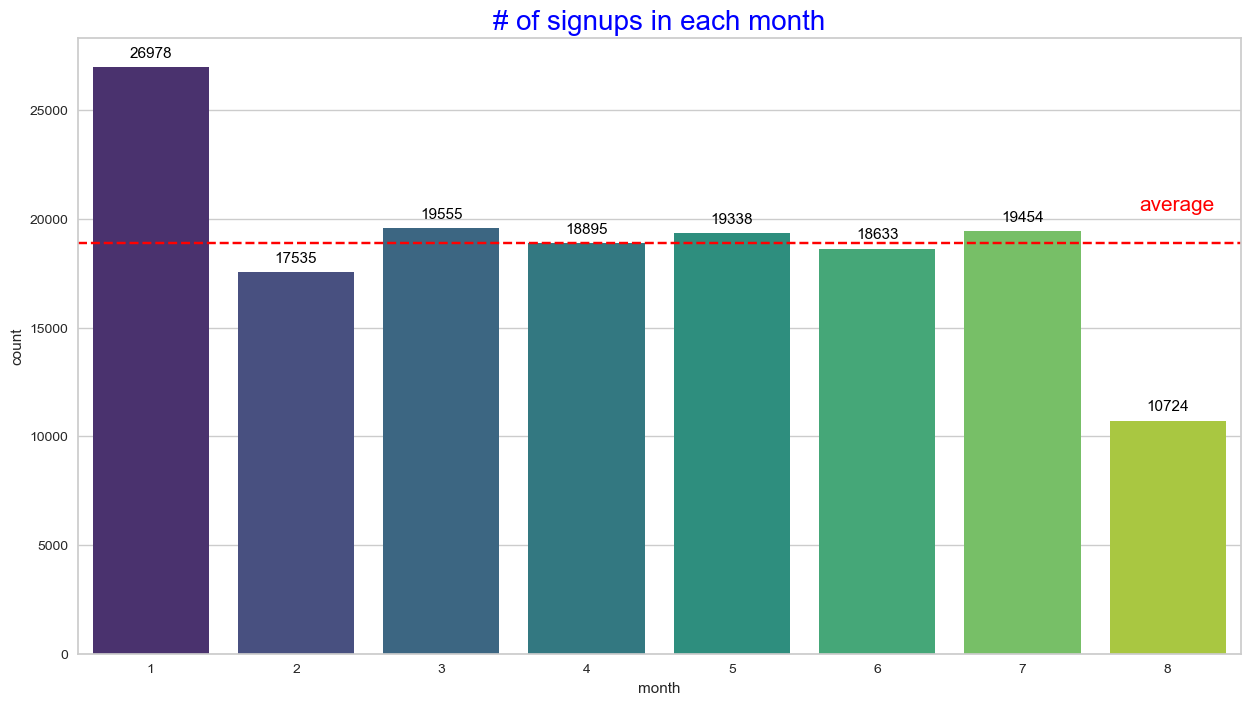

In [82]:
# Create a figure with a larger size
plt.figure(figsize=(15, 8))

# Create a countplot
ax = sns.countplot(x=df['signup_time'].dt.month, palette='viridis')

# Add text labels to the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height()}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                fontsize=11,
                color='black',
                xytext=(0, 10),
                textcoords='offset points')

# Add a title and x-axis label
plt.title('# of signups in each month', size=20, color='blue')
plt.xlabel('month')
plt.axhline(df.groupby(df['signup_time'].dt.month).size().mean(), color='red', ls='--')
plt.text(x=6.8, y=df.groupby(df['signup_time'].dt.month).size().mean()+1500, s='average', color='red', fontsize=15);

***Insights***:
* This dataset only contains month from 1 to 8
* The trend of a high number of signups in January followed by a decline in signups may suggest that there was a specific event or promotion that led to an increase in signups during that month. However, the impact of this event or promotion may have diminished over time, resulting in a decline in signups.
* To better understand the reasons behind this trend and identify opportunities for improving customer acquisition and retention, it may be useful to consider the `following questions`:
    * What was the specific event or promotion that contributed to the increase in signups in January?
    * What changed after January that could have caused the decrease in signups?
    * Are there any seasonal trends or patterns in the data that could explain the decline in signups?
    * `The large number of signups in January could imply fraudulent registration accounts or fraud?`

**Why is signup so high in January? (Fraud?)**

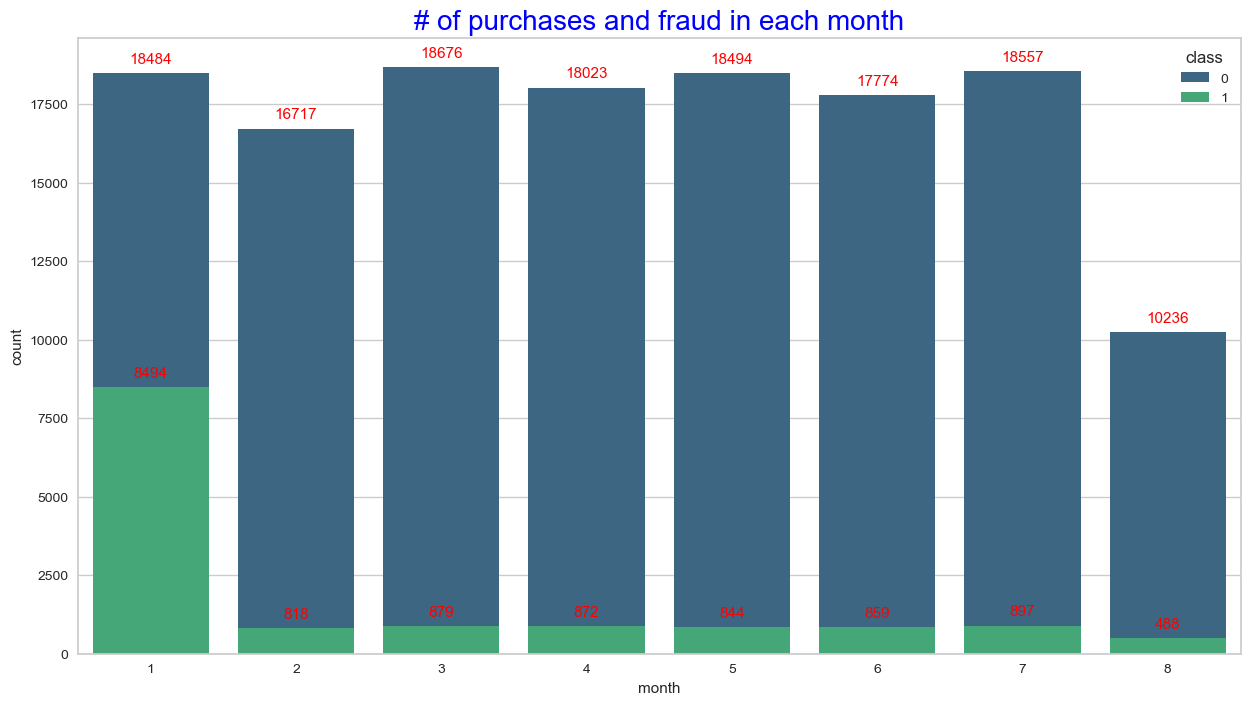

In [83]:
# Create a figure with a larger size
plt.figure(figsize=(15, 8))

# Create a countplot
ax = sns.countplot(x=df['signup_time'].dt.month, palette='viridis',hue=df['class'],dodge=False)

# Add text labels to the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height()}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                fontsize=11,
                color='red',
                xytext=(0, 10),
                textcoords='offset points')

# Add a title and x-axis label
plt.title('# of purchases and fraud in each month', size=20, color='blue')
plt.xlabel('month');

***Insights***:\
aha!!! It shows that the number of legitimate signups was relatively consistent throughout the year, with the exception of a dip in August. However, `there was a spike in the number of fake account signups in January`, which could explain the overall increase in signups that month.

**Number of purchase per month**

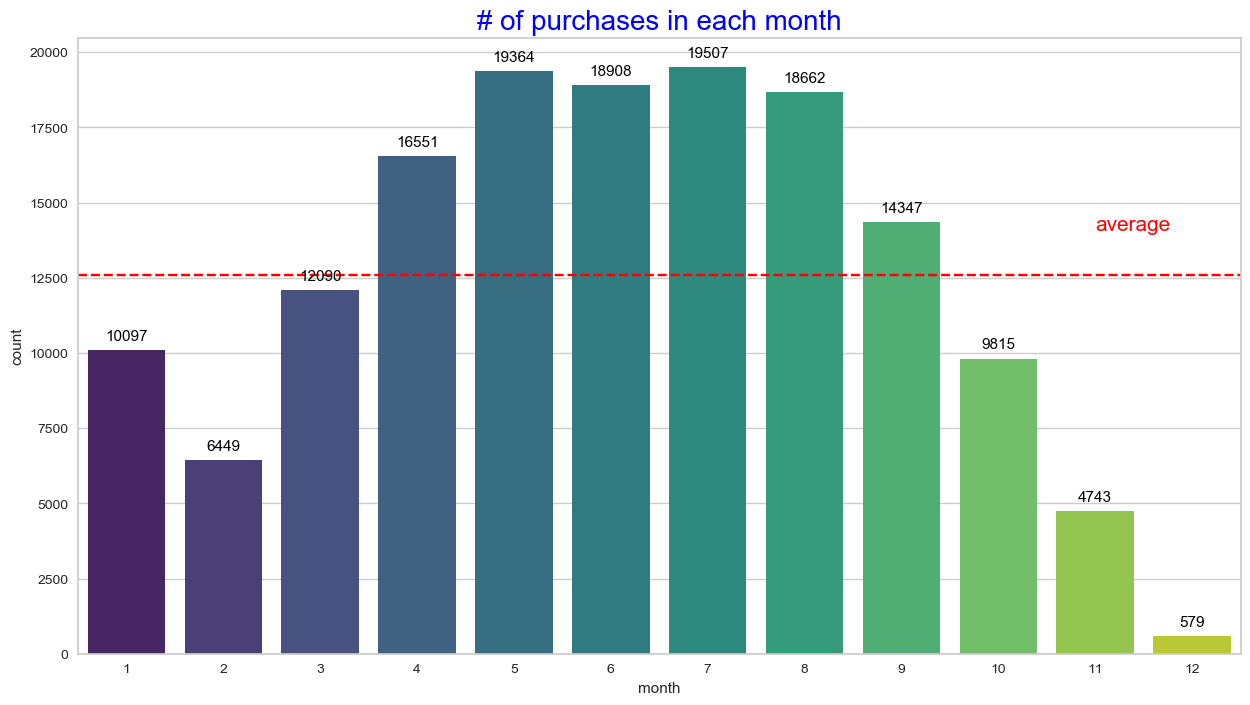

In [84]:
# Create a figure with a larger size
plt.figure(figsize=(15, 8))

# Create a countplot
ax = sns.countplot(x=df['purchase_time'].dt.month, palette='viridis')

# Add text labels to the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height()}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                fontsize=11,
                color='black',
                xytext=(0, 10),
                textcoords='offset points')

# Add a title and x-axis label
plt.title('# of purchases in each month', size=20, color='blue')
plt.xlabel('month')
plt.axhline(df.groupby(df['purchase_time'].dt.month).size().mean(), color='red', ls='--')
plt.text(x=10, y=df.groupby(df['purchase_time'].dt.month).size().mean()+1500, s='average', color='red', fontsize=15);

***Insights***:
* Again, even though the signup was very high in Jan, the number of sales was relatively low number in January.
* One reason that the sales of hand-made clothes are high in summer is due to increasing outdoor events or other factors. So, demand for hand-made clothing may be higher in the warmer months. `This might result in a spike in purchases from May to August`.
* The increase in sales during the summer could also indicate that the company would focus more on client acquisition in January, resulting in a bigger number of signups. However, as the year progresses, `the company's attention may turn to other areas such as client retention or sales, which could result in fewer signups and more transactions.`

**Time difference between signing up and making a purchase**

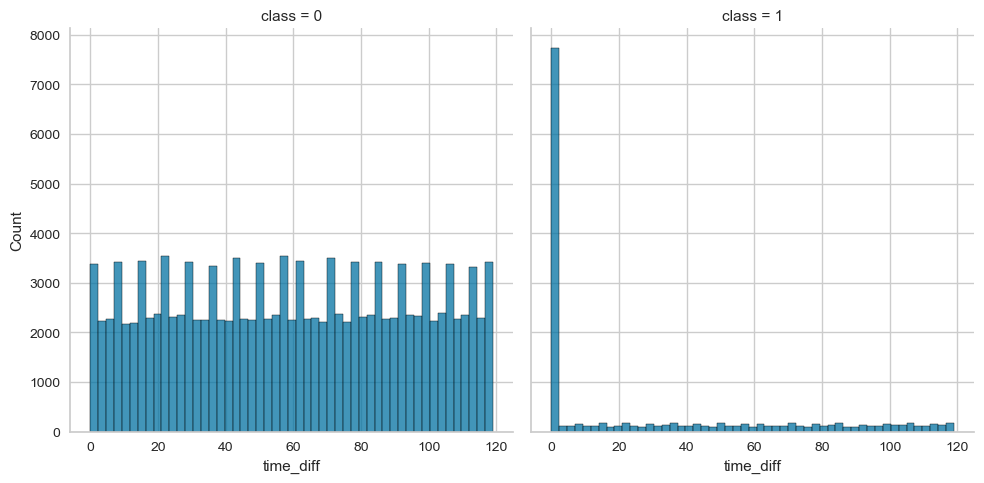

In [85]:
sns.displot(data=df,x='time_diff',col='class');

***Insights***:
* For fake accounts, it appears that nearly all of them made a transaction immediately.
    * This might tell us that the company needs to implement measures such as `enhanced fraud detection and prevention systems, or requiring additional verification for certain types of transactions`.

## 2.2 Purchase Value

In [86]:
df

,signup_time,purchase_time,purchase_value,source,browser,sex,age,class,Country,time_diff
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,SEO,Chrome,M,39,0,Japan,52
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,Ads,Chrome,F,53,0,United States,0
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,SEO,Opera,M,53,1,United States,0
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,SEO,Safari,M,41,0,Missing,5
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,Ads,Safari,M,45,0,United States,50
...,...,...,...,...,...,...,...,...,...,...
151107,2015-01-27 03:03:34,2015-03-29 00:30:47,43,SEO,Chrome,M,28,1,United States,60
151108,2015-05-15 17:43:29,2015-05-26 12:24:39,35,SEO,Safari,M,32,0,Netherlands,10
151109,2015-03-03 23:07:31,2015-05-20 07:07:47,40,SEO,IE,F,26,0,Japan,77
151110,2015-07-09 20:06:07,2015-09-07 09:34:46,46,SEO,Chrome,M,37,0,United States,59


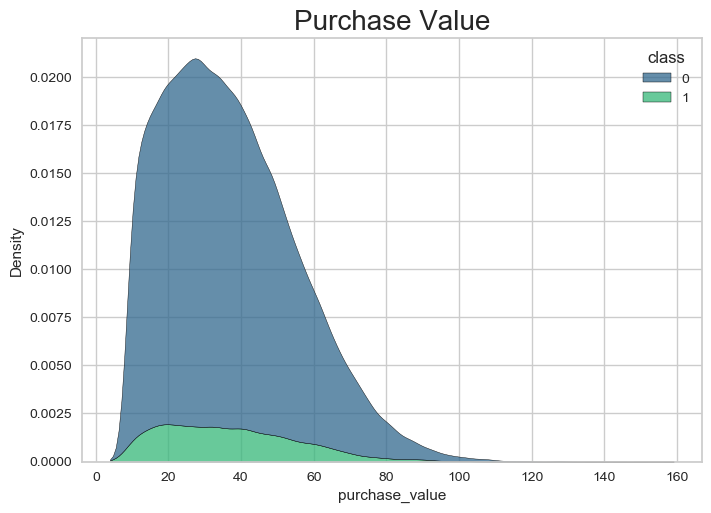

In [87]:
sns.kdeplot(data=df,x='purchase_value',hue='class',multiple='stack',palette='viridis')
plt.title('Purchase Value',size=20);

# 3. Machine Learning

**Pre-processing**

In [88]:
#save a copy
data = df

Convert signup_time and purchase_time into quarter for drawing insights

In [89]:
df['signup_time_quarter'] = df['signup_time'].dt.quarter
df['purchase_time_quarter'] = df['purchase_time'].dt.quarter
df['signup_time_quarter'] = df['signup_time_quarter'].astype('object')
df['purchase_time_quarter'] = df['purchase_time_quarter'].astype('object')

df.drop(['signup_time','purchase_time'],axis=1,inplace=True)

In [90]:
df.head()

,purchase_value,source,browser,sex,age,class,Country,time_diff,signup_time_quarter,purchase_time_quarter
0,34,SEO,Chrome,M,39,0,Japan,52,1,2
1,16,Ads,Chrome,F,53,0,United States,0,2,2
2,15,SEO,Opera,M,53,1,United States,0,1,1
3,44,SEO,Safari,M,41,0,Missing,5,2,2
4,39,Ads,Safari,M,45,0,United States,50,3,3


In [91]:
df.nunique()

purchase_value           122
source                     3
browser                    5
sex                        2
age                       58
class                      2
Country                  182
time_diff                120
signup_time_quarter        3
purchase_time_quarter      4
dtype: int64

Create a continent column to replace country

In [92]:
import pycountry_convert as pc

def country_to_continent(country_name):
        #test if there is an error
    try: 
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    except:
        country_continent_name = country_name
    return country_continent_name

In [93]:
#create the continent column
df['Continent'] = df['Country'].apply(lambda x: country_to_continent(x))
df.drop('Country',axis=1,inplace=True)

In [94]:
df.nunique()

purchase_value           122
source                     3
browser                    5
sex                        2
age                       58
class                      2
time_diff                120
signup_time_quarter        3
purchase_time_quarter      4
Continent                 24
dtype: int64

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   purchase_value         151112 non-null  int64 
 1   source                 151112 non-null  object
 2   browser                151112 non-null  object
 3   sex                    151112 non-null  object
 4   age                    151112 non-null  int64 
 5   class                  151112 non-null  int64 
 6   time_diff              151112 non-null  int64 
 7   signup_time_quarter    151112 non-null  object
 8   purchase_time_quarter  151112 non-null  object
 9   Continent              151112 non-null  object
dtypes: int64(4), object(6)
memory usage: 11.5+ MB


In [96]:
df_category = df.select_dtypes(['object']).astype('category')
print('These are the reference levels') 
print('-'*30)
df_category.apply(lambda x: x.cat.categories[0])

These are the reference levels
------------------------------


source                      Ads
browser                  Chrome
sex                           F
signup_time_quarter           1
purchase_time_quarter         1
Continent                Africa
dtype: object

In [97]:
X = df.drop('class',axis=1)
y = df['class']

In [98]:
X = pd.get_dummies(X,drop_first=True)
X.head()

,purchase_value,age,time_diff,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,...,Continent_Moldova Republic of,Continent_North America,Continent_Oceania,Continent_Palestinian Territory Occupied,Continent_Reunion,Continent_Slovakia (SLOVAK Republic),Continent_South America,Continent_Taiwan; Republic of China (ROC),Continent_Tanzania United Republic of,Continent_Virgin Islands (U.S.)
0,34,39,52,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,16,53,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,15,53,0,0,1,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
3,44,41,5,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,39,45,50,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0


**We can see that there are lots of columns (high dimensionality). We could apply PCA to reduce it**

## PCA

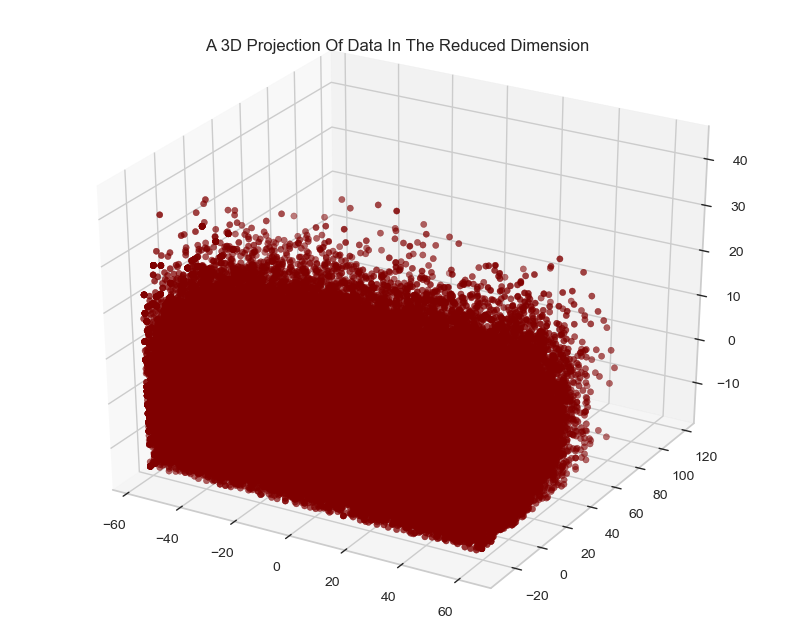

In [109]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(X)
PCA_ds = pd.DataFrame(pca.transform(X), columns=(["col1","col2",'col3']))
PCA_ds.describe().T

a =PCA_ds["col1"]
b =PCA_ds["col2"]
c =PCA_ds["col3"]

#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(a,b,c, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension");

## Clustering

Let us quickly visualize the groupings using clustering

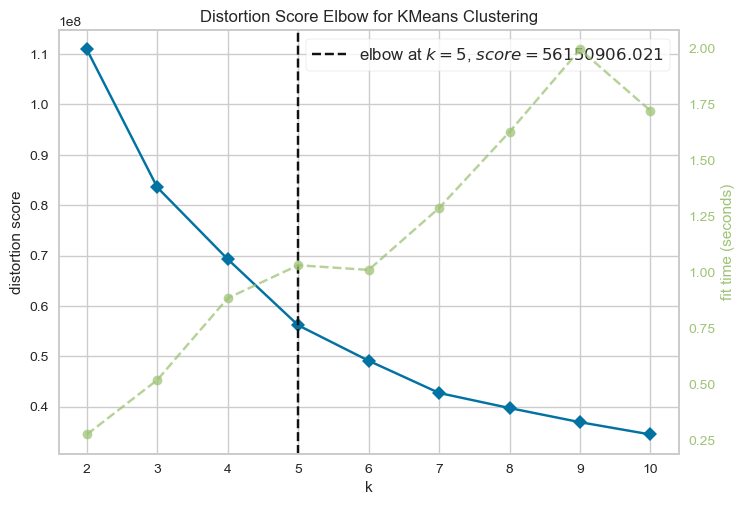

In [120]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering

# Quick examination of elbow method to find numbers of clusters to make.
Elbow_M = KElbowVisualizer(KMeans(random_state=42), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show();

In [121]:
clus = df.copy()

#Initiating the Agglomerative Clustering model 
AC = KMeans(n_clusters=5) # elbow = 5
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
clus["Clusters"]= yhat_AC

In [122]:
PCA_ds.sample(5)

,col1,col2,col3,Clusters
29603,-51.655300,-19.835062,-14.119403,1
23925,-44.655310,-19.822531,5.881367,1
53351,-56.605874,2.195027,-1.151895,1
91683,-43.653703,-19.846598,-9.118648,1
7380,46.376895,-6.039420,2.874532,3


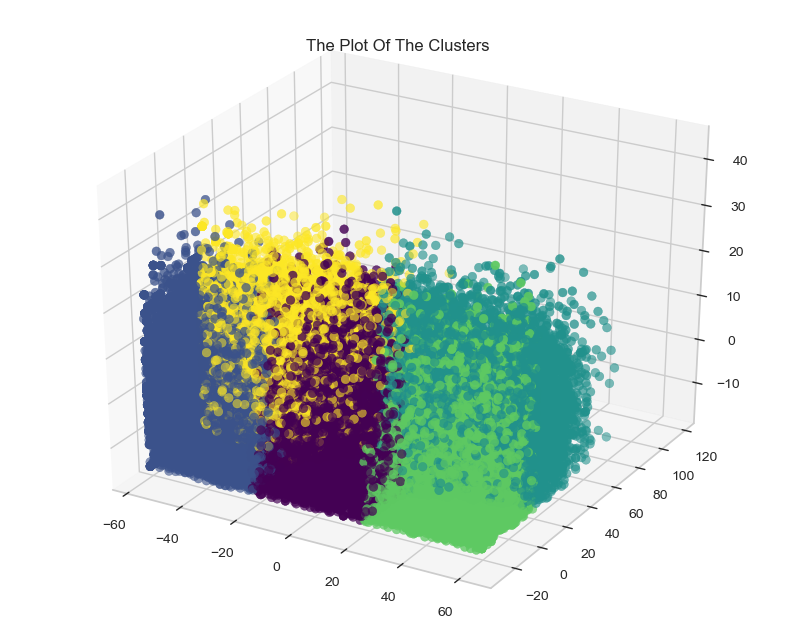

In [123]:
a =PCA_ds["col1"]
b =PCA_ds["col2"]
c =PCA_ds["col3"]

#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(a, b, c, s=40, c=PCA_ds["Clusters"], marker='o',cmap='viridis')
ax.set_title("The Plot Of The Clusters")
plt.show()

Text(0.5, 1.0, 'Distribution Of The Clusters')

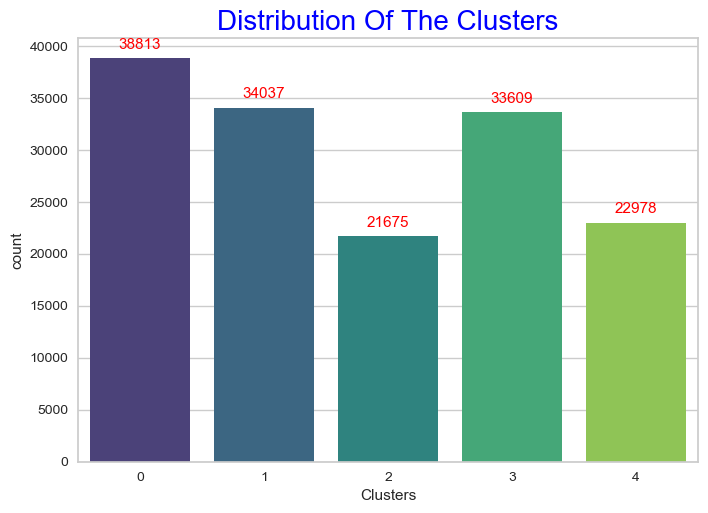

In [124]:
#Plotting countplot of clusters
ax = sns.countplot(x=clus["Clusters"], palette= 'viridis')

# Add text labels to the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height()}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                fontsize=11,
                color='red',
                xytext=(0, 10),
                textcoords='offset points')
    
ax.set_title("Distribution Of The Clusters",size=20,color='blue')

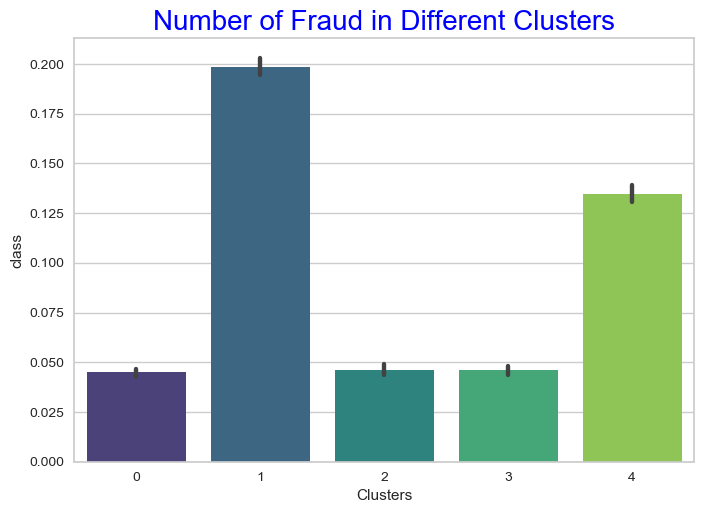

In [125]:
sns.barplot(y='class', x='Clusters', data=clus, palette='viridis')
plt.title("Number of Fraud in Different Clusters",size=20,color='blue');

**Insights**:
* We can see that there are lots of fraud in cluster 1 followed by cluster 4
* Let's further investigate each clusters' characteristics 

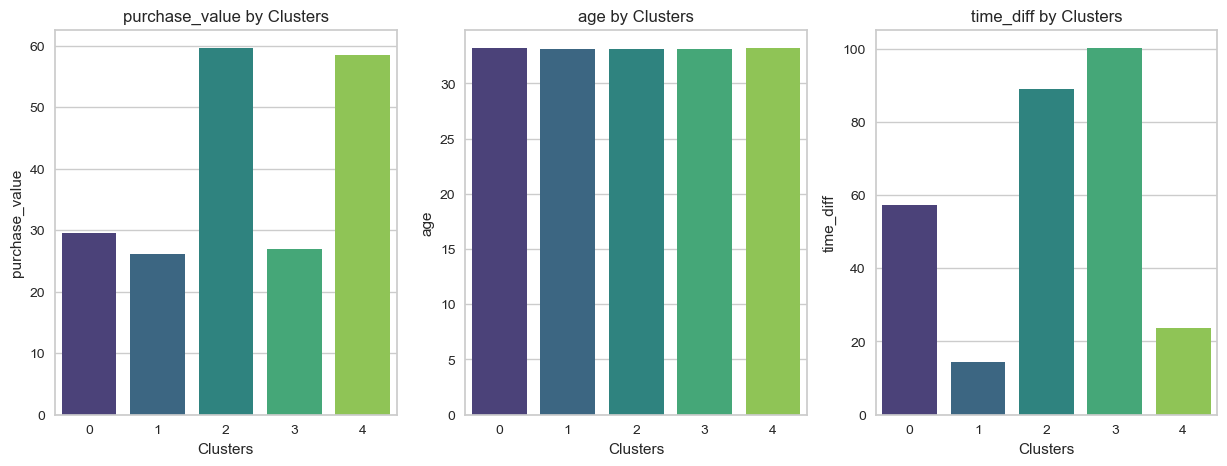

In [150]:
# Create a list of columns to plot
numeric_columns = ['purchase_value', 'age',
       'time_diff']

# Set the number of rows and columns for the subplots
nrows = 1
ncols = 3

# Create a figure and axes for the subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5))

# Flatten the axes object to a single list of axes
axs = axs.flatten()

# Iterate over the numeric columns and plot each one using a barplot
for ax, column in zip(axs[:len(numeric_columns)], numeric_columns):
    sns.barplot(x='Clusters', y=column, data=clus, palette='viridis', ax=ax, ci=None)
    ax.set_title(f"{column} by Clusters")


**Insights**:
* Yes, it looks like the time_diff column may be a useful feature for detecting fraud, as it seems to differ significantly between the different clusters that have high and low numbers of frauds.
* One way to further visualize this relationship is to use a box plot to compare the distribution of time_diff values between the clusters that have high and low numbers of frauds. You can use the following code to create a box plot:

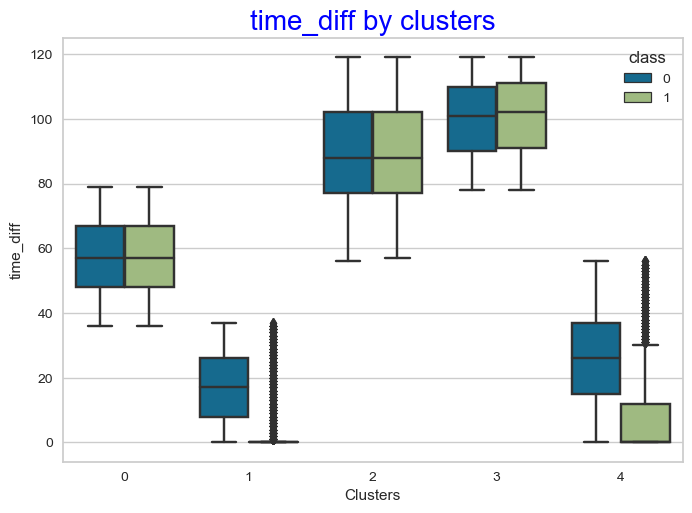

In [174]:
sns.boxplot(x='Clusters', y='time_diff', hue='class', data=clus)
plt.title('time_diff by clusters',size=20,color='blue');

**Insights**:
* Yes, it looks like the time_diff column may be an important feature for detecting fraud, as it seems to differ significantly between the different clusters that have high and low numbers of frauds.
* In particular, the clusters with the highest numbers of frauds (cluster 1 and 4) seem to have much lower values of time_diff compared to the other clusters. This suggests that low values of time_diff may be a good indicator of fraud.
* To further investigate this relationship, we could try creating additional plots or summary statistics to see if there are any other patterns or trends that might be useful for detecting fraud. We could also consider using machine learning techniques to build a model that can predict fraud based on the time_diff and other relevant features in the data.

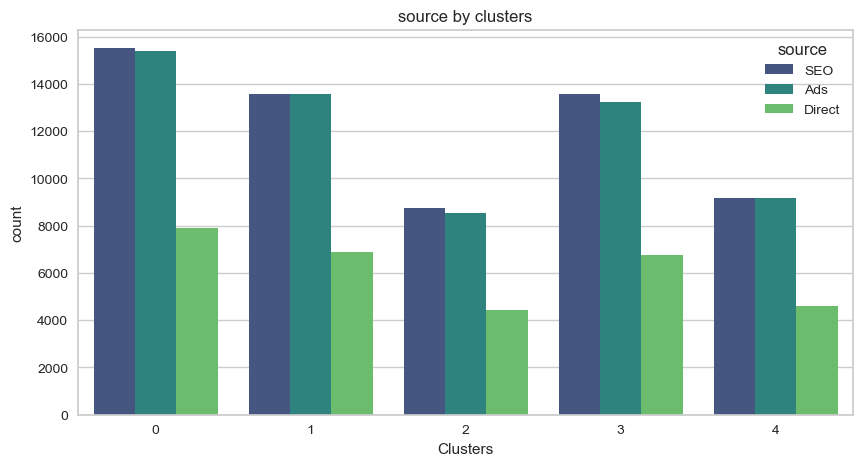

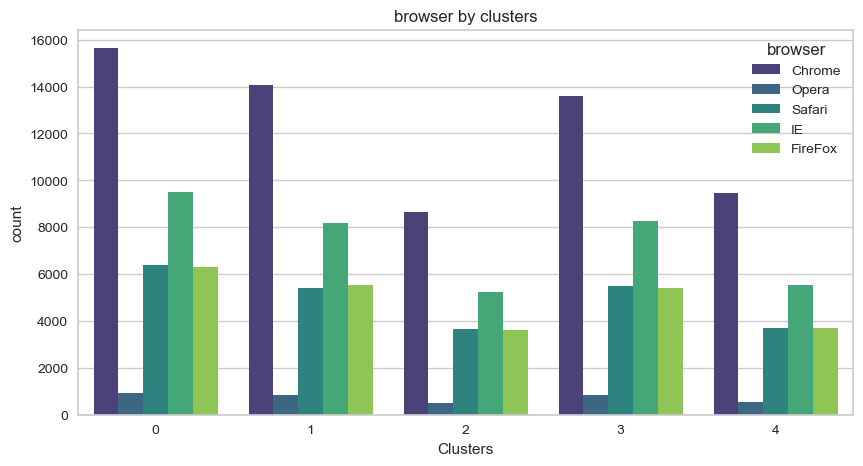

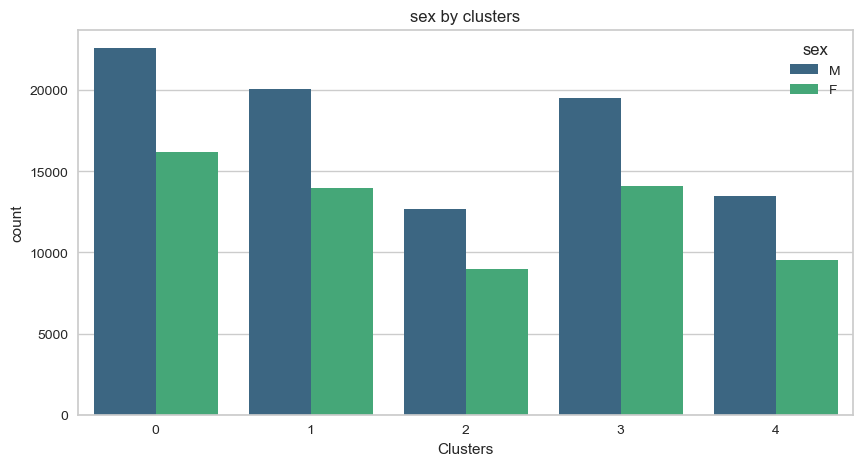

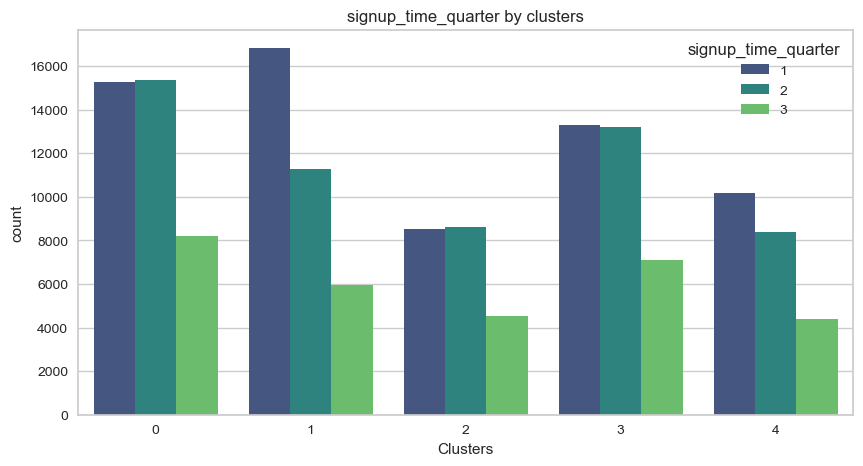

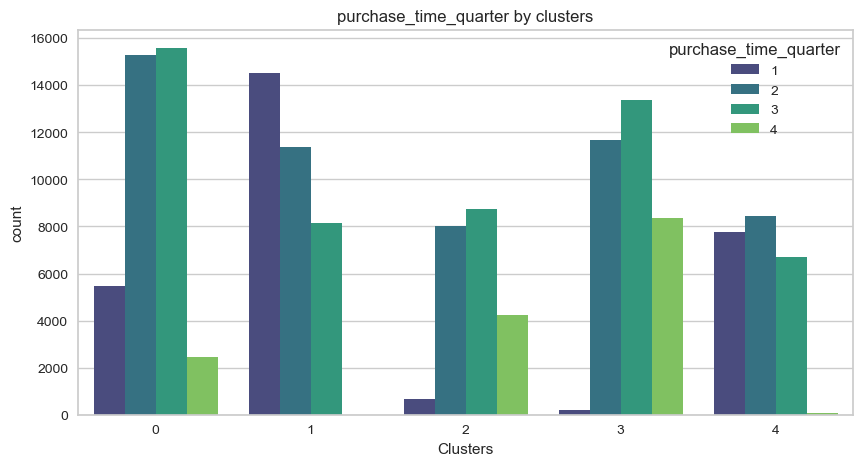

In [181]:
object_columns = ['source', 'browser', 'sex', 'signup_time_quarter', 'purchase_time_quarter']
plot_columns = object_columns

# Loop through each column and create a countplot
for col in plot_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x='Clusters', hue=col, data=clus,palette='viridis')
    plt.title(f'{col} by clusters')
    plt.show()

**Insights**:
* We are unable to find any patterns or trends that stand out in the object plots, it may be that the relationships between the clusters column and the other columns in object_columns are not strong or clear.
* We could try using machine learning techniques to build a model that can predict the class column based on the values in the clusters and object_columns columns.

## Model Building

**I will use random forests and XGBoost for both explanatory and predictive purposes.** 

* Random forests and XGBoost are both powerful machine learning algorithms that are well-suited for a wide range of tasks. They are able to handle high-dimensional data and can provide accurate predictions even when dealing with complex and nonlinear relationships. Additionally, they offer some interpretability, which can be useful for understanding the underlying patterns and relationships in the data.
* In addition to potentially improving interpretability, using tree-based models can also be a good way to handle missing values in the Continent column. Tree-based models such as decision trees and random forests can handle missing values by simply treating them as another category. This can be a useful way to impute missing values without having to drop rows or fill them in with a fixed value.

In [195]:
print('imbalanced dataset')
print('-'*20)
y.value_counts()

imbalanced dataset
--------------------


0    136961
1     14151
Name: class, dtype: int64

**Train Test Split**

In [192]:
from sklearn.model_selection import train_test_split

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

**Models**

In [268]:
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import (StratifiedKFold, GridSearchCV,
                                     RandomizedSearchCV,
                                     RepeatedStratifiedKFold, cross_validate)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    make_scorer,
    fbeta_score,
    precision_score,
    f1_score,
    roc_auc_score,
    recall_score,
    accuracy_score,
)

dum_model = DummyClassifier(strategy='stratified', random_state=42)
# This is often used as a baseline model to compare the performance of other classifiers

**Tune models with gridsearch**

In [203]:
#param grid to tune
XGB_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'scale_pos_weight': [5, 10, 20]
}

RF_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

In [204]:
model_param_grid = {
    'dummy': [dum_model, {}],
    'RF': [RandomForestClassifier(), RF_param_grid],
    'XGBoost': [XGBClassifier(), XGB_param_grid],
}

In [206]:
for name, [model, param_grid] in model_param_grid.items():
    print(name, model)

dummy DummyClassifier(random_state=42, strategy='stratified')
RF RandomForestClassifier()
XGBoost XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [217]:
train_model = {}
for name, [model, param_grid] in model_param_grid.items():
    cv = StratifiedKFold(n_splits=5)
    grid = RandomizedSearchCV(estimator=model, scoring='f1', cv=cv, param_distributions=param_grid,random_state=42)
    # Fit the grid search object to the training data
    grid.fit(X_train, y_train)
    # Store the best estimator found by grid search in the dictionary
    train_model[name] = grid.best_estimator_


In [225]:
train_copy = train_model.copy()

results = {}

for name, model in train_copy.items():
    
    cv = RepeatedStratifiedKFold(n_repeats=3,n_splits=10,random_state=42)
    score = cross_validate(estimator=model, X=X, y=y, scoring=['roc_auc', 'f1', 'precision', 'recall'], cv=cv)
    results[name] = {
    'roc_auc': score['test_roc_auc'],
    'f1': score['test_f1'],
    'precision': score['test_precision'],
    'recall': score['test_recall']
    }


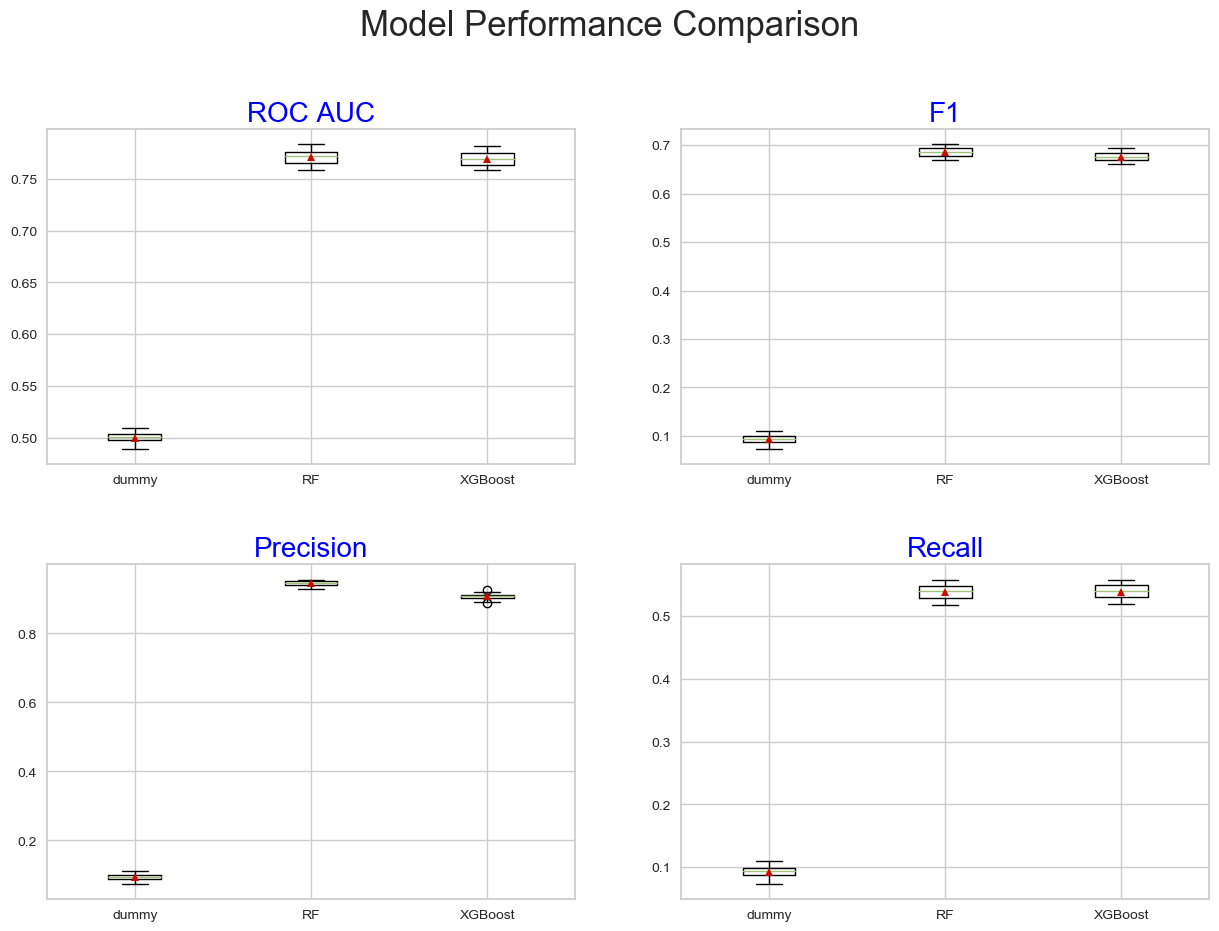

In [226]:
def plot_performance():

    # Extract the ROC AUC, F1, precision, and recall scores from the results
    roc_auc = [result['roc_auc'] for result in results.values()]
    f1 = [result['f1'] for result in results.values()]
    precision = [result['precision'] for result in results.values()]
    recall = [result['recall'] for result in results.values()]

    # Create a figure with 2 rows and 2 columns of subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    plt.suptitle("Model Performance Comparison", fontsize=25, y=1)

    # Plot the boxplots for the ROC AUC metric
    axs[0, 0].boxplot(roc_auc, labels=results.keys(), showmeans=True)
    axs[0, 0].set_title("ROC AUC", size=20, color='blue')

    # Plot the boxplots for the F1 metric
    axs[0, 1].boxplot(f1, labels=results.keys(), showmeans=True)
    axs[0, 1].set_title("F1", size=20, color='blue')

    # Plot the boxplots for the precision metric
    axs[1, 0].boxplot(precision, labels=results.keys(), showmeans=True)
    axs[1, 0].set_title("Precision", size=20, color='blue')

    # Plot the boxplots for the recall metric
    axs[1, 1].boxplot(recall, labels=results.keys(), showmeans=True)
    axs[1, 1].set_title("Recall", size=20, color='blue')

plot_performance()

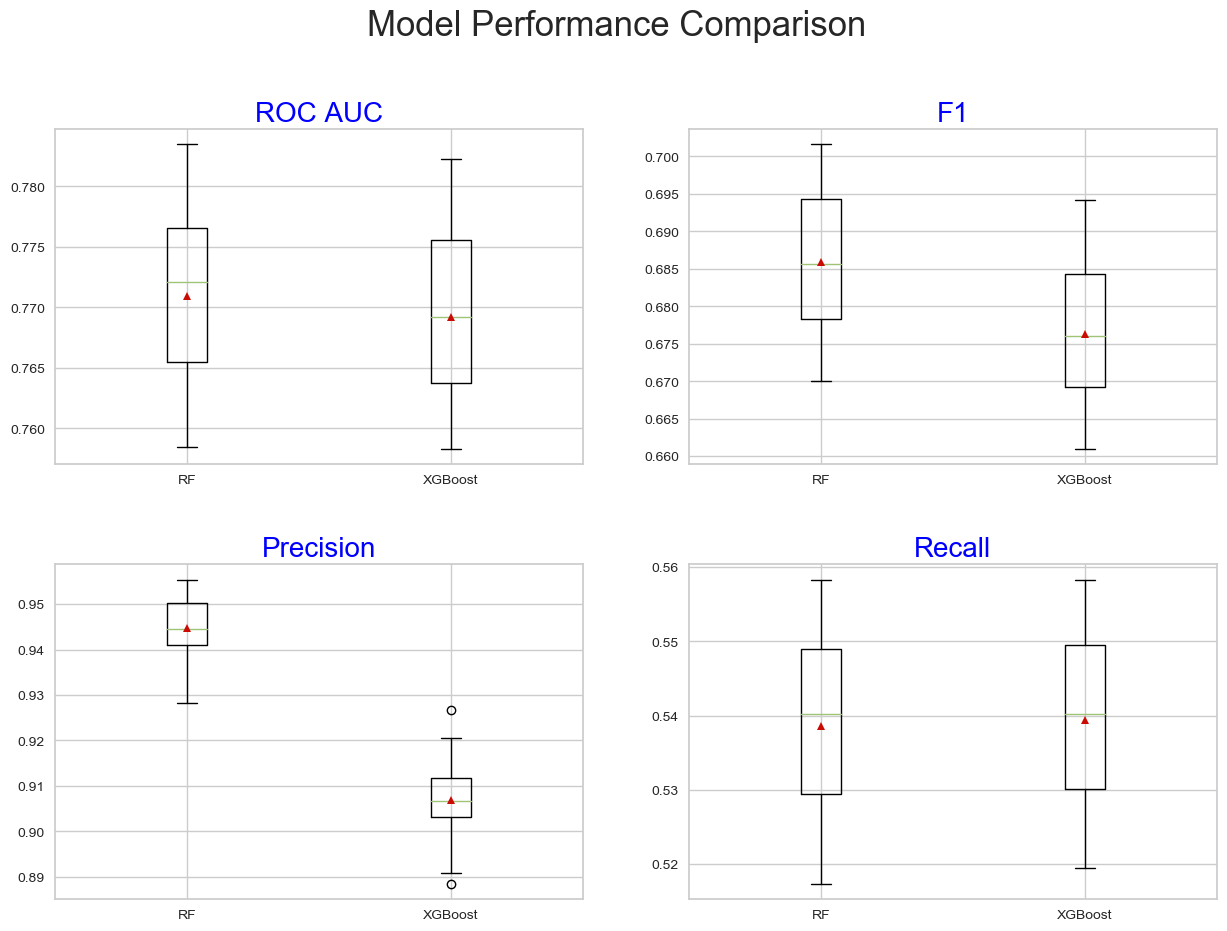

In [232]:
# look closer by dropping dummy
del results['dummy']
plot_performance()

**Predictions**

In [240]:
from sklearn.metrics import classification_report

In [245]:
print(classification_report(y_test,train_model['RF'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     13696
           1       0.94      0.53      0.68      1415

    accuracy                           0.95     15111
   macro avg       0.95      0.76      0.83     15111
weighted avg       0.95      0.95      0.95     15111



In [244]:
print(classification_report(y_test,train_model['XGBoost'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     13696
           1       0.91      0.55      0.68      1415

    accuracy                           0.95     15111
   macro avg       0.93      0.77      0.83     15111
weighted avg       0.95      0.95      0.95     15111



**Insights**:
* Overall, random forests performed slightly better.

**Important Features**

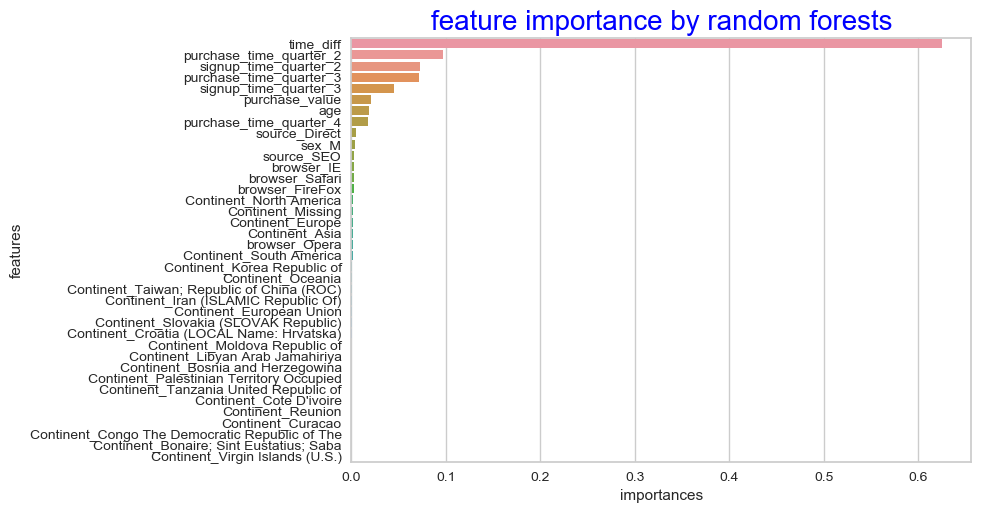

In [267]:
#random forests
tb = pd.DataFrame({'features': X.columns, 'importances': train_model['RF'].feature_importances_})
tb = tb.sort_values('importances', ascending=False)

# Plot the barplot
sns.barplot(x='importances', y='features', data=tb)
plt.title('feature importance by random forests',color='blue',size=20)
plt.show()

**Insights**:

*What is feature importance?*
* In the context of fraud detection, tree-based feature importance can be a valuable tool for understanding which features are most important in predicting fraudulent activity. The feature importance can tell us which features were most influential in predicting fraud. This can help a business identify patterns or characteristics that are commonly associated with fraudulent activity, and to focus their efforts on detecting and preventing these types of fraud.
* Additionally, tree-based feature importance can help a business prioritize which features to focus on when building a fraud detection model. For example, if certain features are found to be much more important in predicting fraud than others, a business may choose to prioritize those features when building their model in order to maximize its performance.

*Insights*
* From a business standpoint, the information that "time_diff" is a very important feature in detecting fraudulent activities, followed by "purchase_time" and "sign up time" in quarter 2 and 3, suggests that the timing of activities is an important factor in identifying fraudulent behavior. Specifically, the difference in time between certain activities, as well as the timing of those activities within a given quarter, may be useful indicators of fraudulent activity.
    * This information could be useful to a business in a number of ways. For example, a business could use this information to prioritize monitoring certain types of activities or transactions that occur within specific timeframes, in order to more effectively detect and prevent fraudulent activity. Additionally, a business could use this information to implement controls or policies that focus on the timing of activities in order to reduce the risk of fraud.

**Let's try to select important features and see how the performance change**

In [277]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score

thresholds = np.sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(train_model['RF'], threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = RandomForestClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    f1 = f1_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, F1: %.2f%%" %
          (thresh, select_X_train.shape[1], f1 * 100.0))

Thresh=0.000, n=38, F1: 67.87%
Thresh=0.000, n=38, F1: 67.87%
Thresh=0.000, n=38, F1: 67.93%
Thresh=0.000, n=38, F1: 67.90%
Thresh=0.000, n=38, F1: 67.87%
Thresh=0.000, n=38, F1: 67.87%
Thresh=0.001, n=22, F1: 67.96%
Thresh=0.001, n=21, F1: 67.87%
Thresh=0.002, n=17, F1: 67.96%
Thresh=0.002, n=16, F1: 68.02%
Thresh=0.002, n=15, F1: 68.05%
Thresh=0.002, n=14, F1: 67.69%
Thresh=0.002, n=12, F1: 67.47%
Thresh=0.003, n=10, F1: 66.87%
Thresh=0.003, n=10, F1: 66.78%
Thresh=0.003, n=10, F1: 66.81%
Thresh=0.003, n=10, F1: 66.75%
Thresh=0.004, n=9, F1: 65.94%
Thresh=0.004, n=9, F1: 65.80%
Thresh=0.004, n=9, F1: 65.91%
Thresh=0.004, n=9, F1: 65.86%
Thresh=0.004, n=8, F1: 65.50%
Thresh=0.004, n=8, F1: 65.12%
Thresh=0.005, n=8, F1: 65.29%
Thresh=0.005, n=8, F1: 65.32%
Thresh=0.005, n=8, F1: 65.24%
Thresh=0.005, n=8, F1: 65.44%
Thresh=0.005, n=8, F1: 65.27%
Thresh=0.006, n=8, F1: 65.44%
Thresh=0.006, n=8, F1: 65.38%
Thresh=0.006, n=8, F1: 65.27%
Thresh=0.009, n=8, F1: 65.27%
Thresh=0.063, n=4, F1: 

As the number of selected features decreases, the model's performance tends to decline. However, using feature selection can be beneficial when training a model on a large dataset, especially if cross-validation is being used. Without feature selection, training a model on a large dataset can be very time-consuming. In the past, we trained a model on a dataset without performing feature selection and it took 20 minutes to complete. If the dataset were even larger, the training time would likely have been even longer. Therefore, we could consider using feature selection because it can help to improve the efficiency of the model training process (maybe select thresh at 0.002).

**Partial Dependence plot**\
A partial dependence plot is a graphical tool used in machine learning to visualize the relationship between a target variable and a set of features, while holding all other features constant. It helps to understand how a particular feature affects the target variable, and can be used to identify patterns and trends in the data.

Time_diff

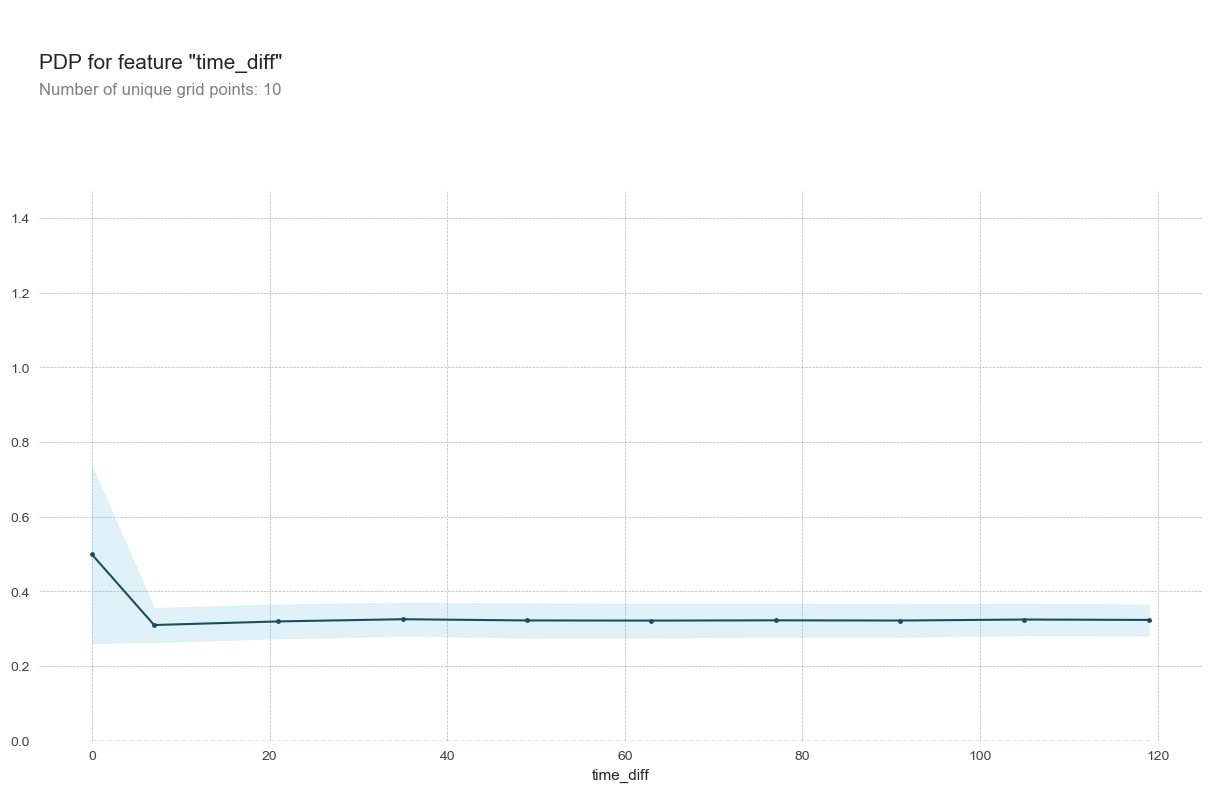

In [291]:
from pdpbox import pdp, info_plots

feat_original = X.columns
train_cols = X

pdp_version = pdp.pdp_isolate(model=train_model['RF'],
                              dataset=train_cols,
                              model_features=list(train_cols),
                             feature='time_diff')
pdp.pdp_plot(pdp_version, 'time_diff', center=False);

**Insights**:
* The plot illustrates that there is a higher probability of fraudulent activity occurring when the time difference between events is small.

<div class="mark">
We will create a separate PDP plot for each feature in X, which may result in a lengthy figure.</div><i class="fa fa-lightbulb-o "></i>

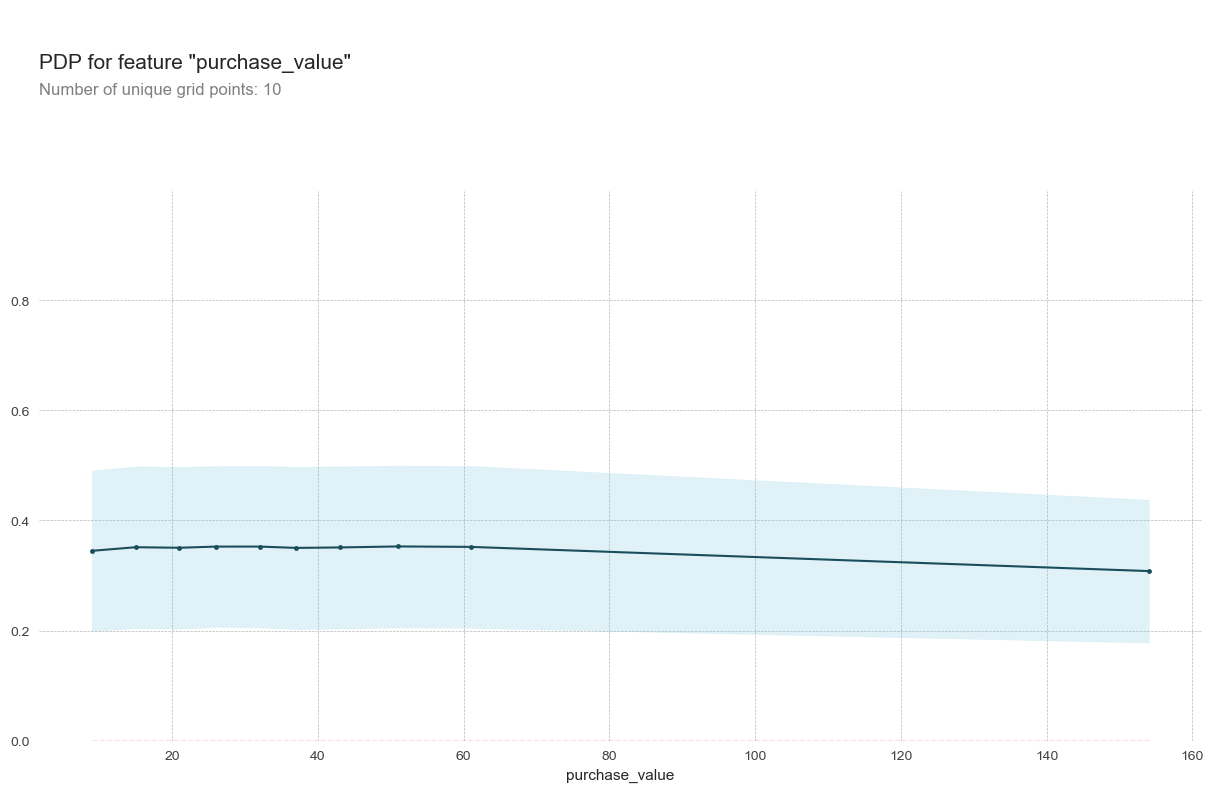

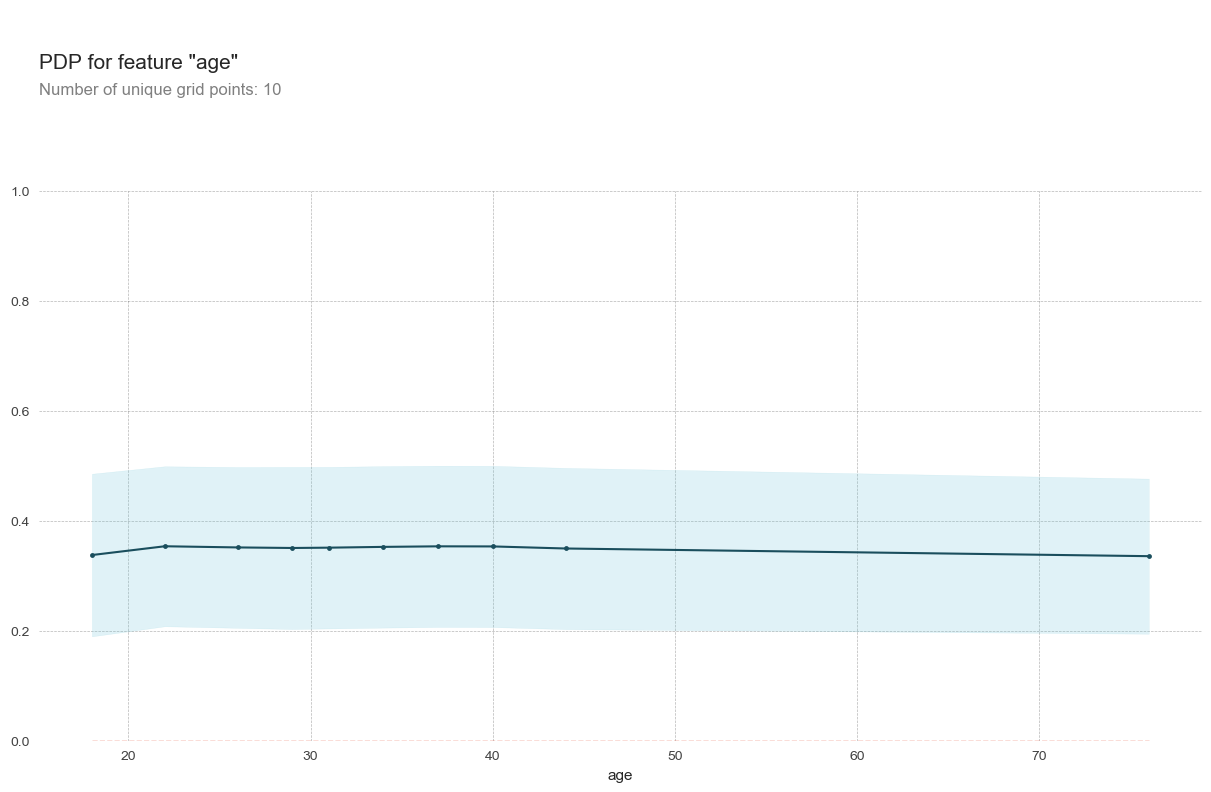

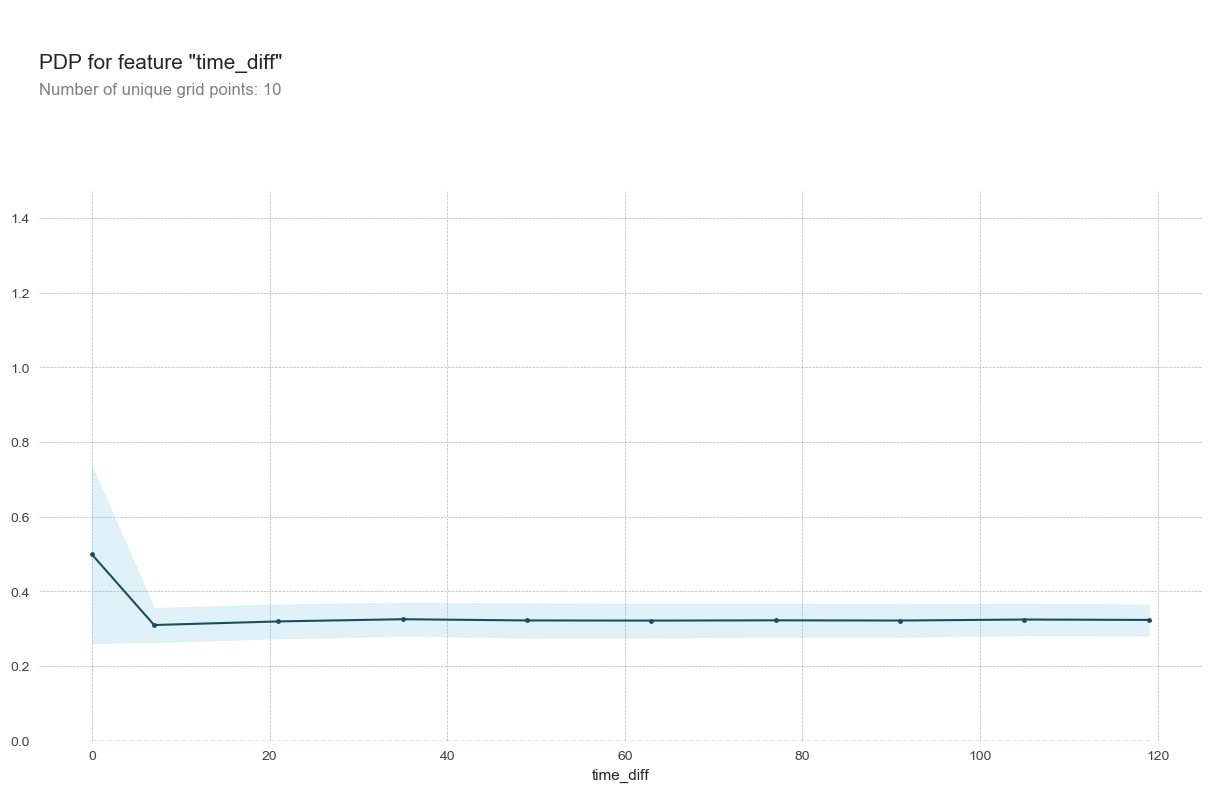

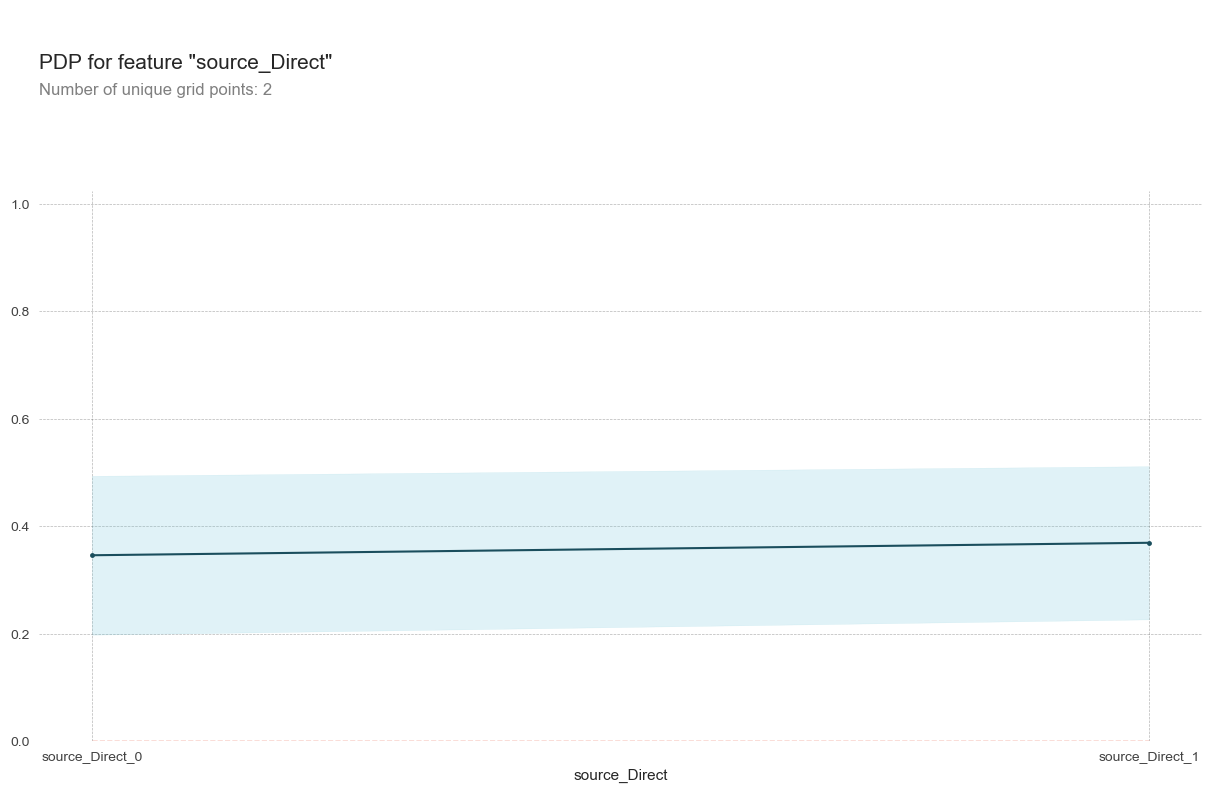

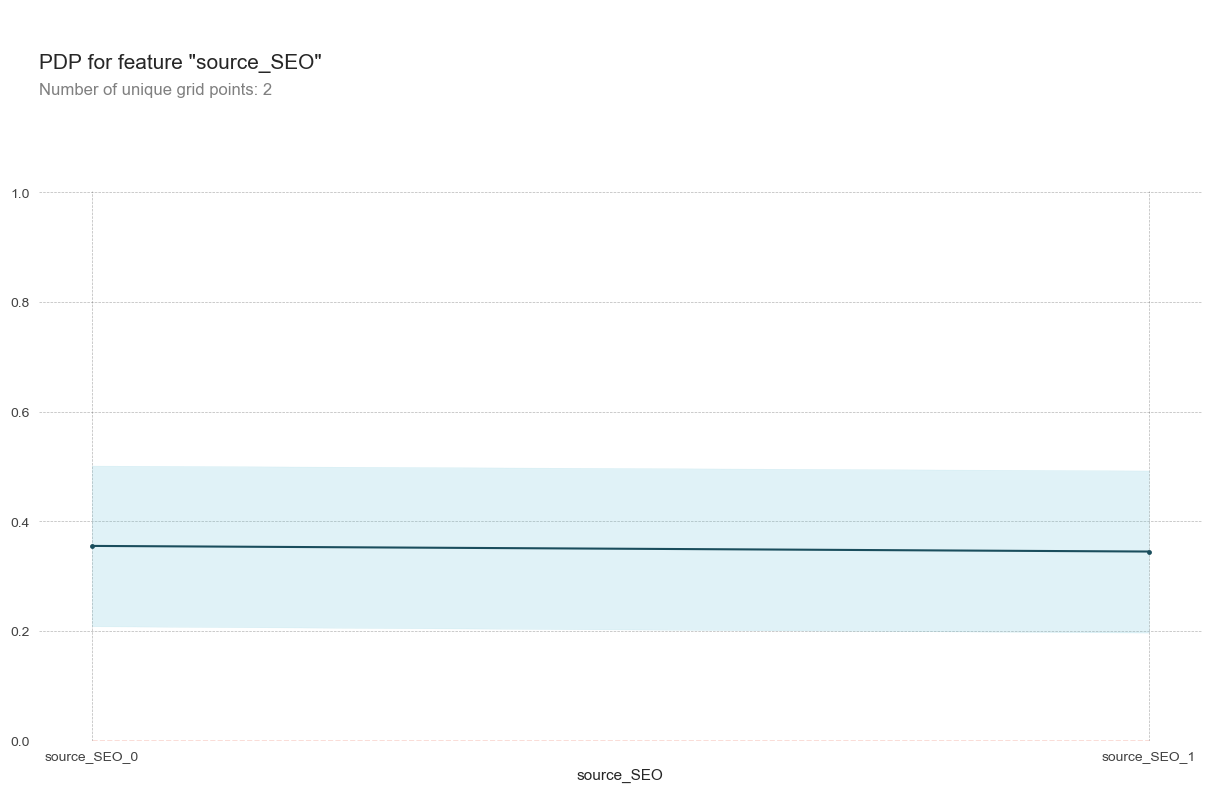

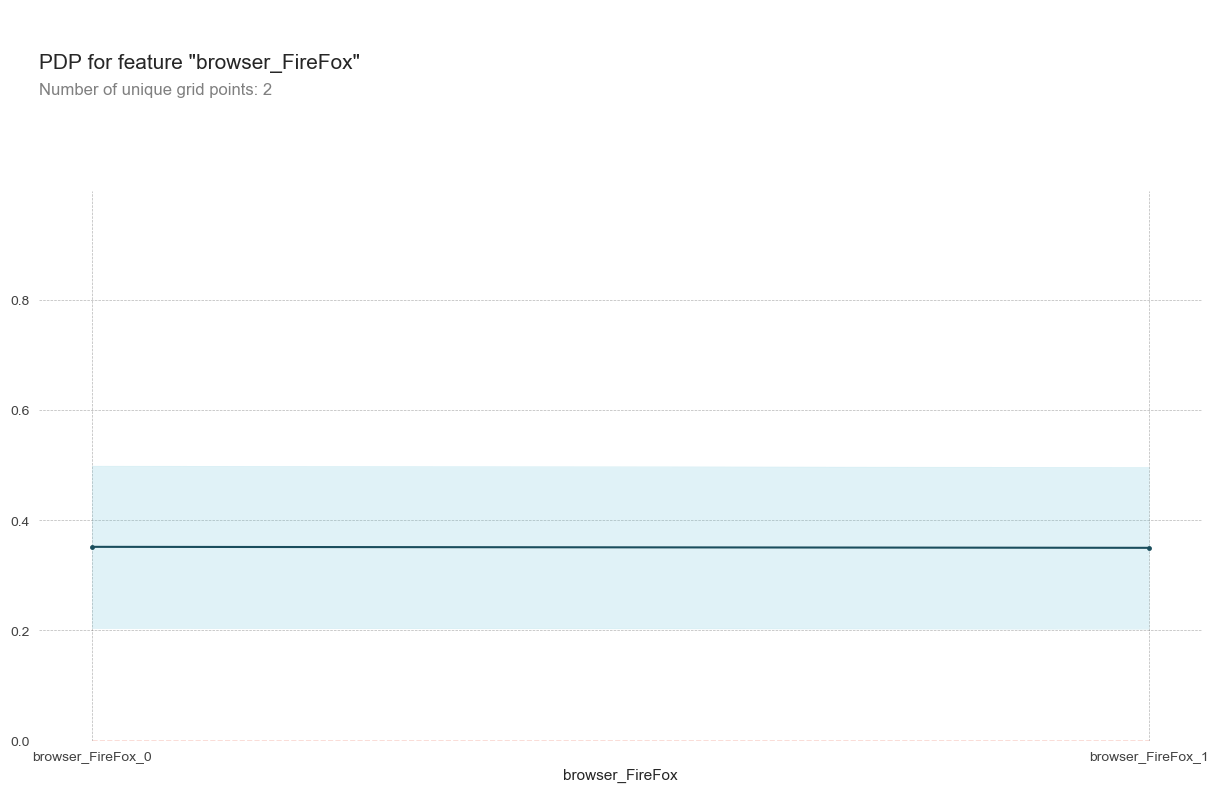

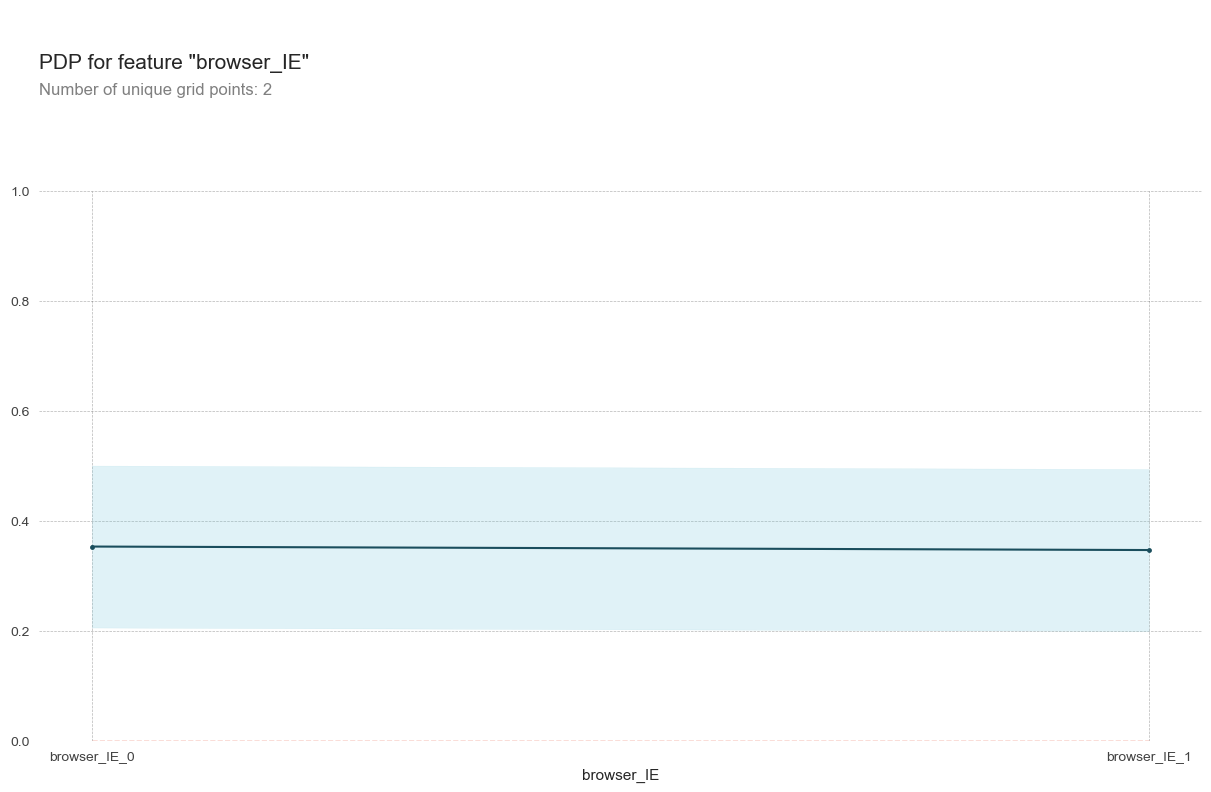

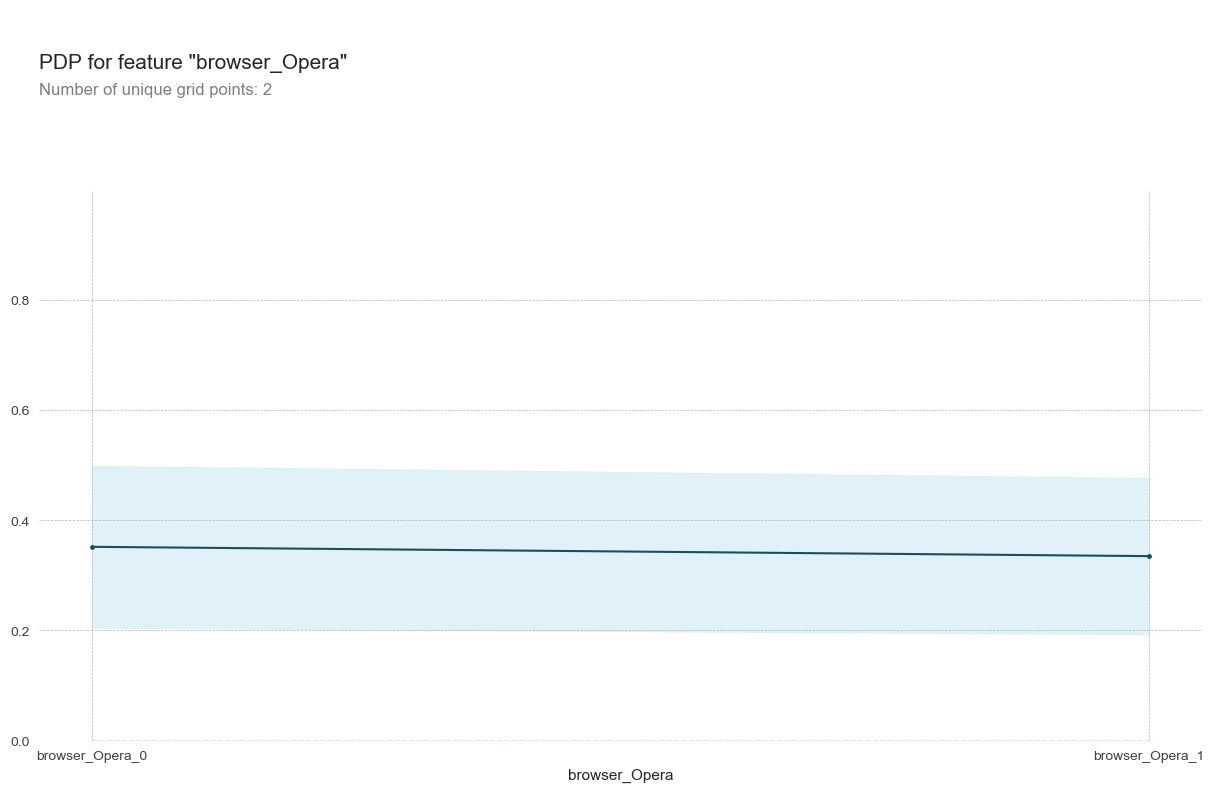

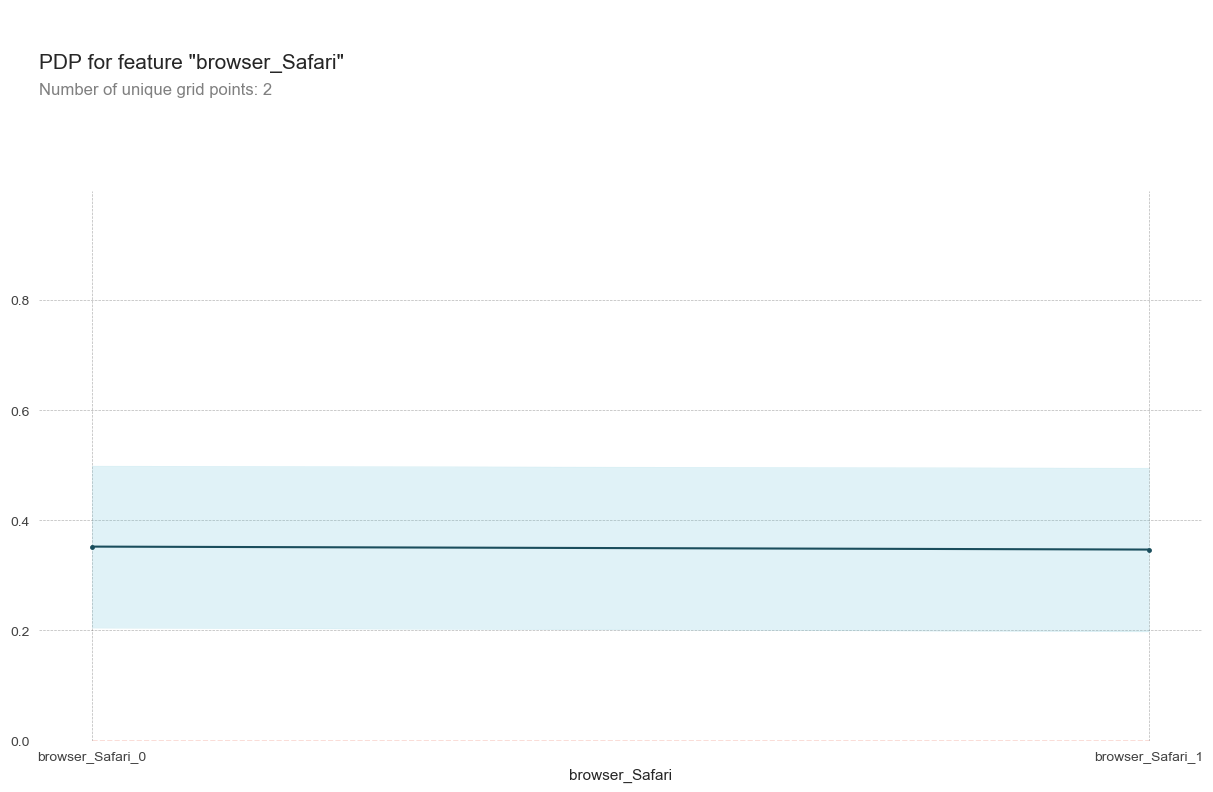

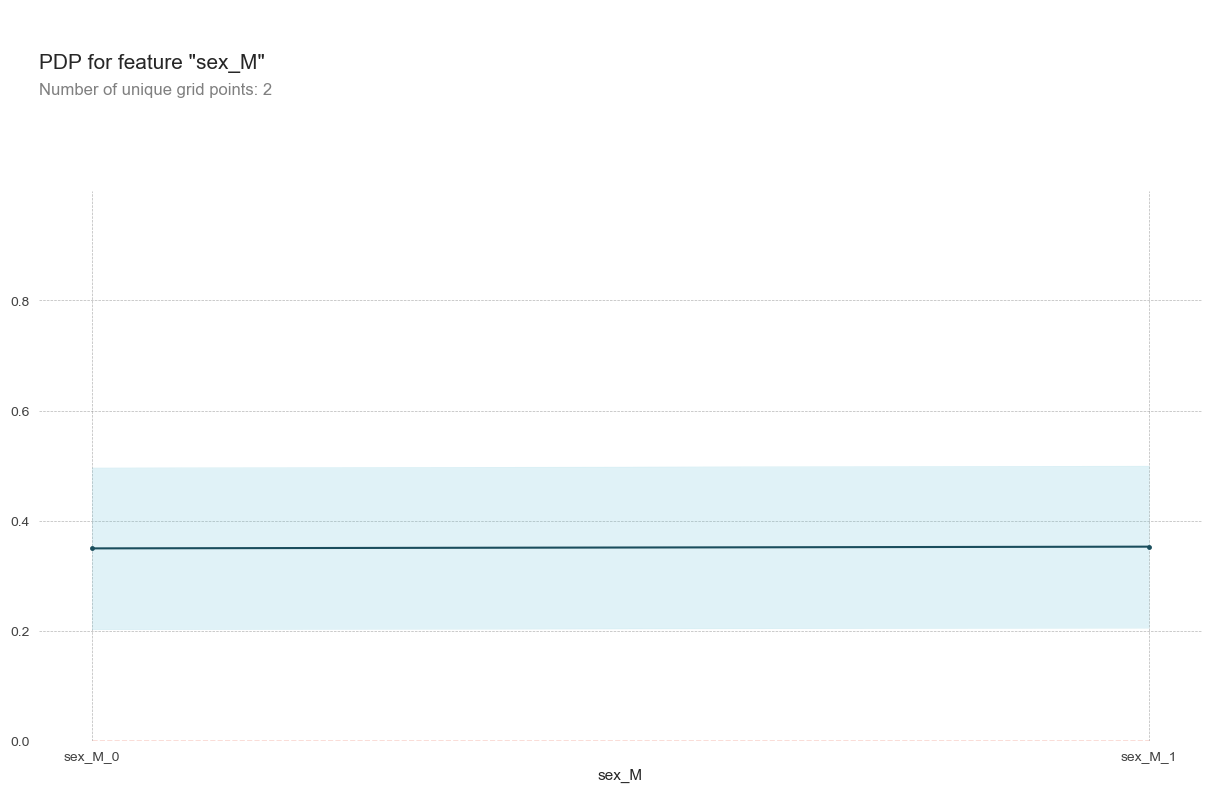

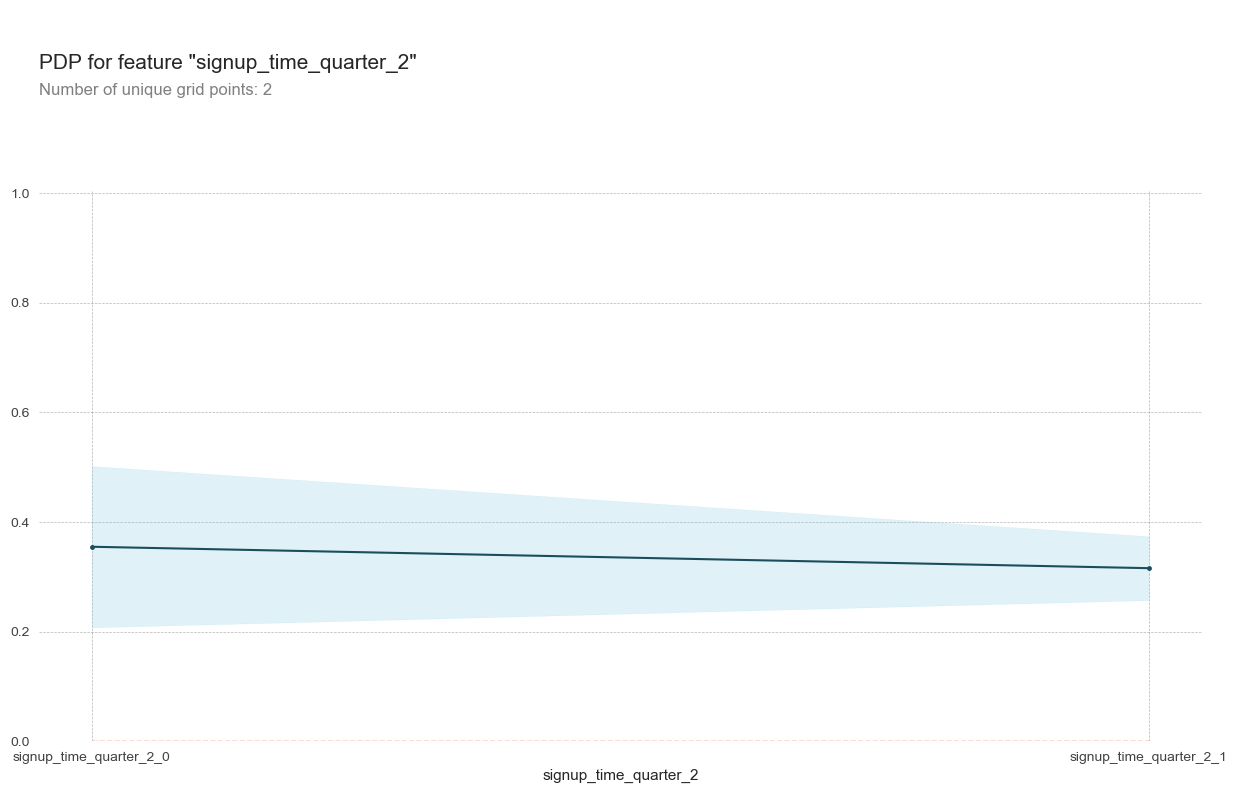

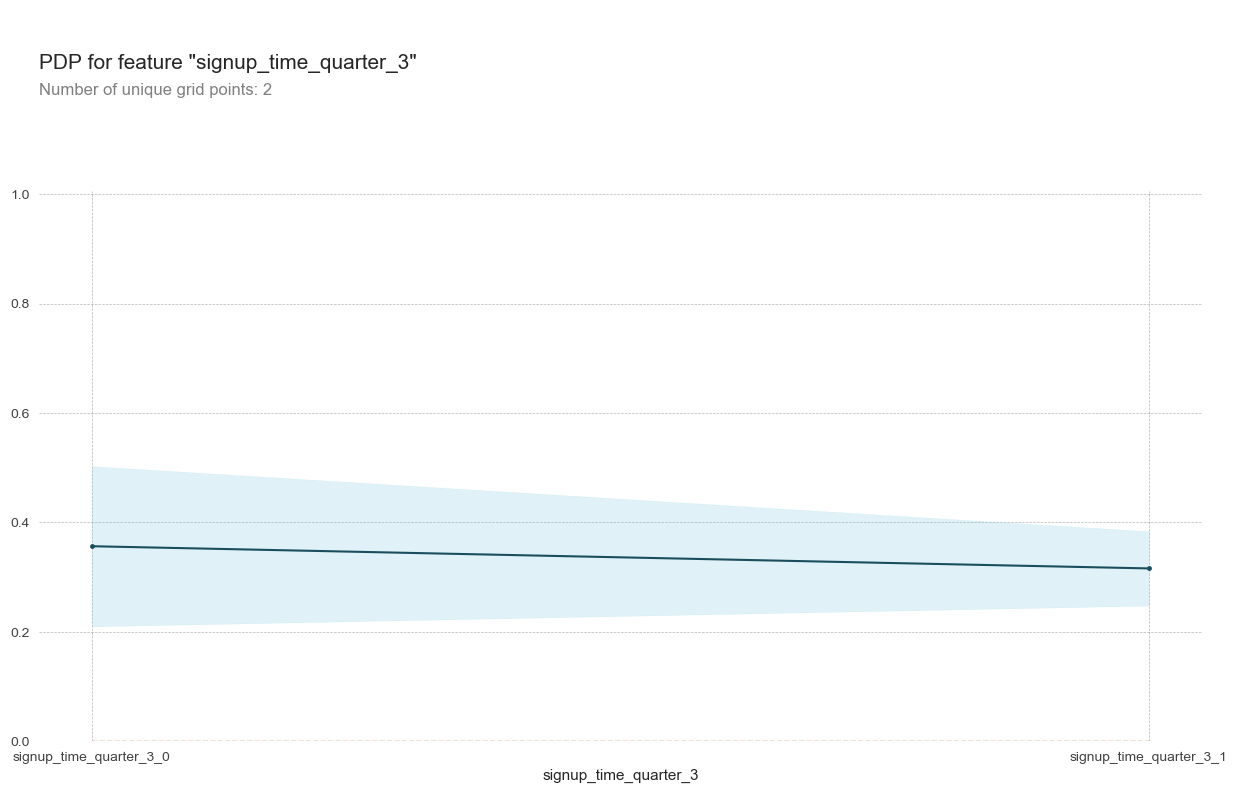

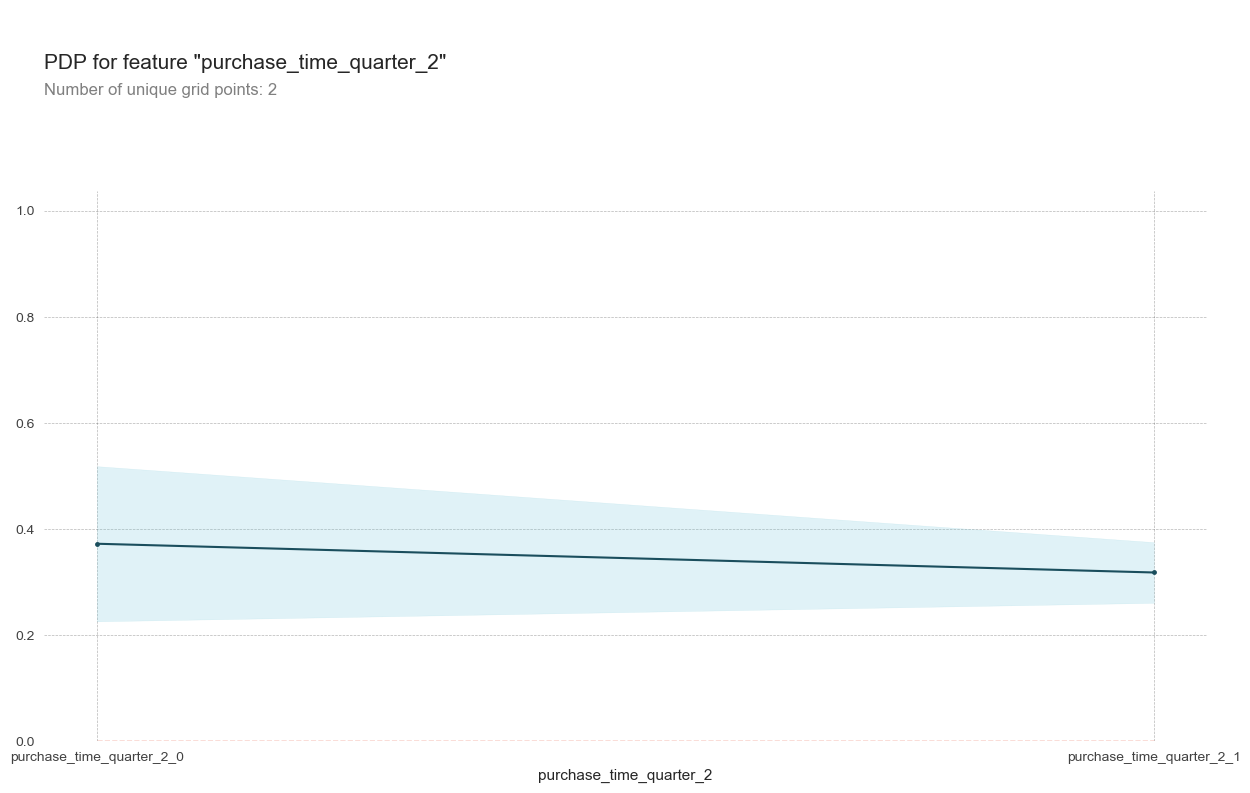

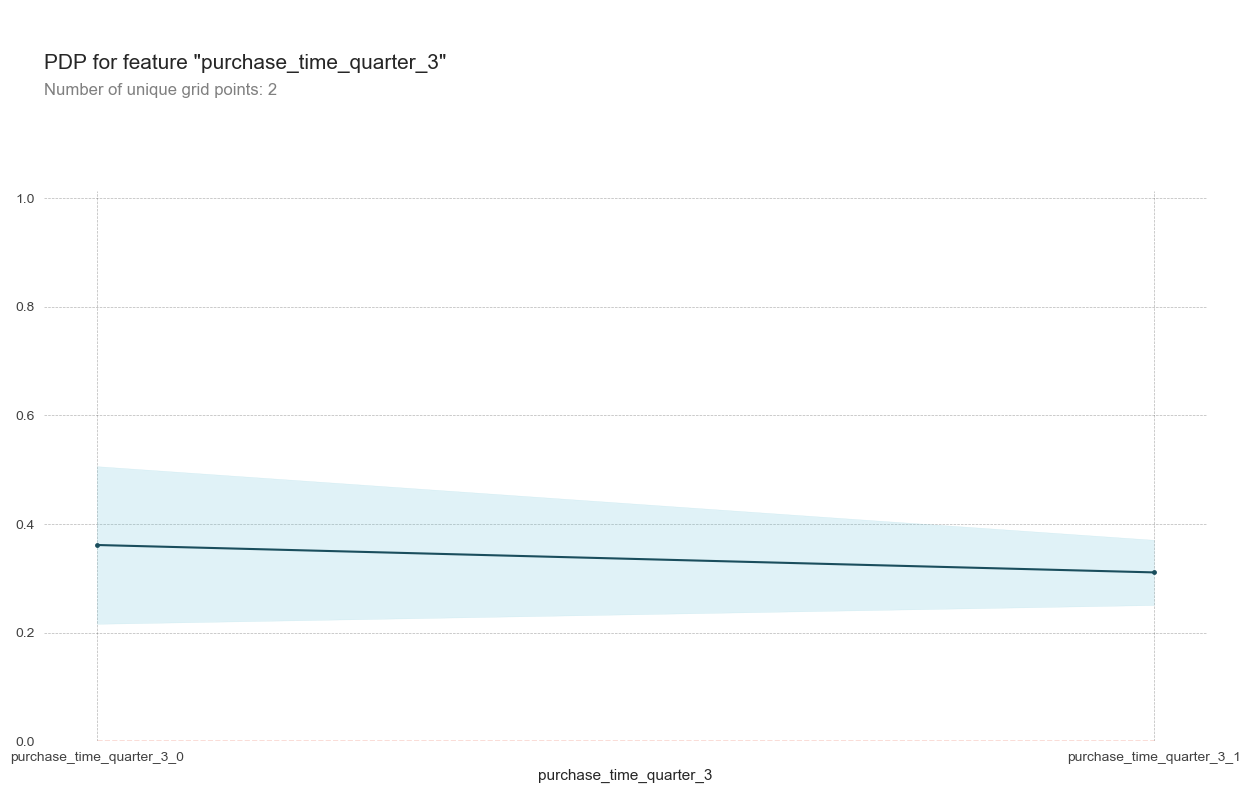

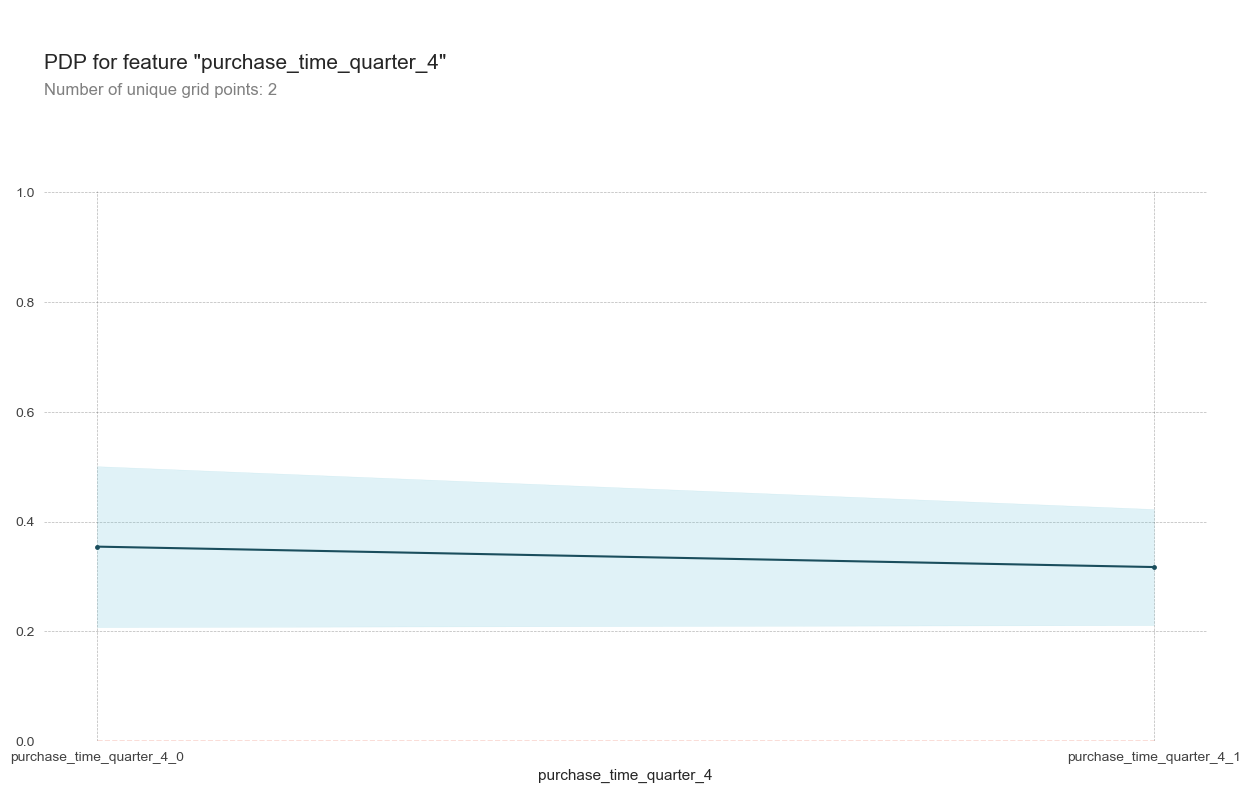

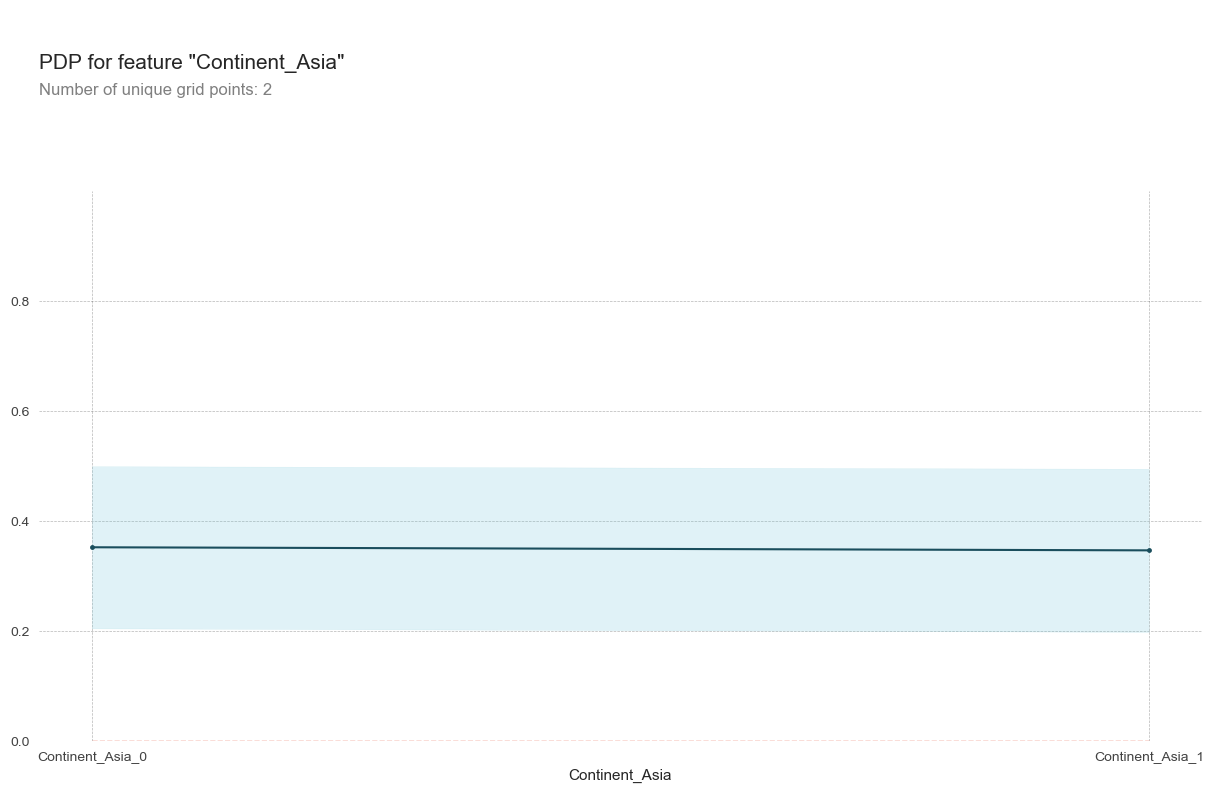

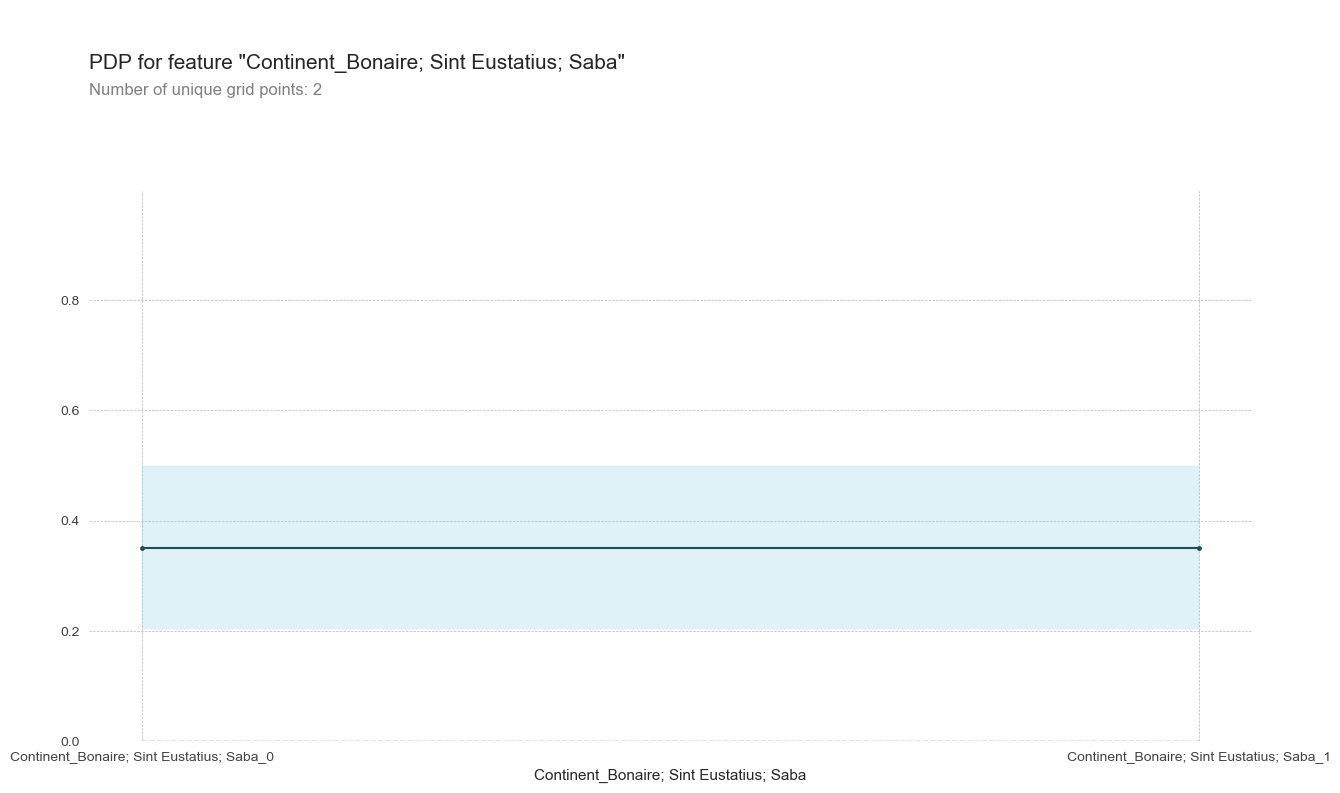

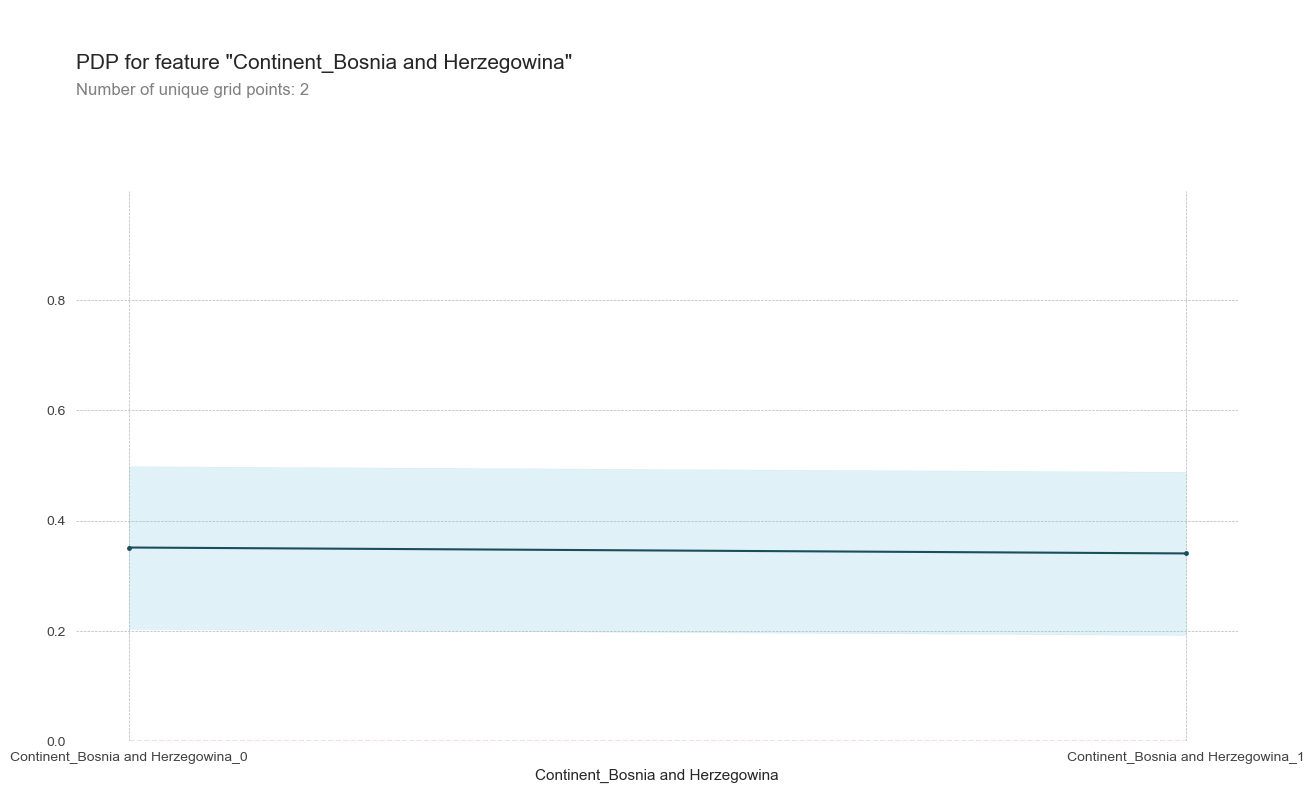

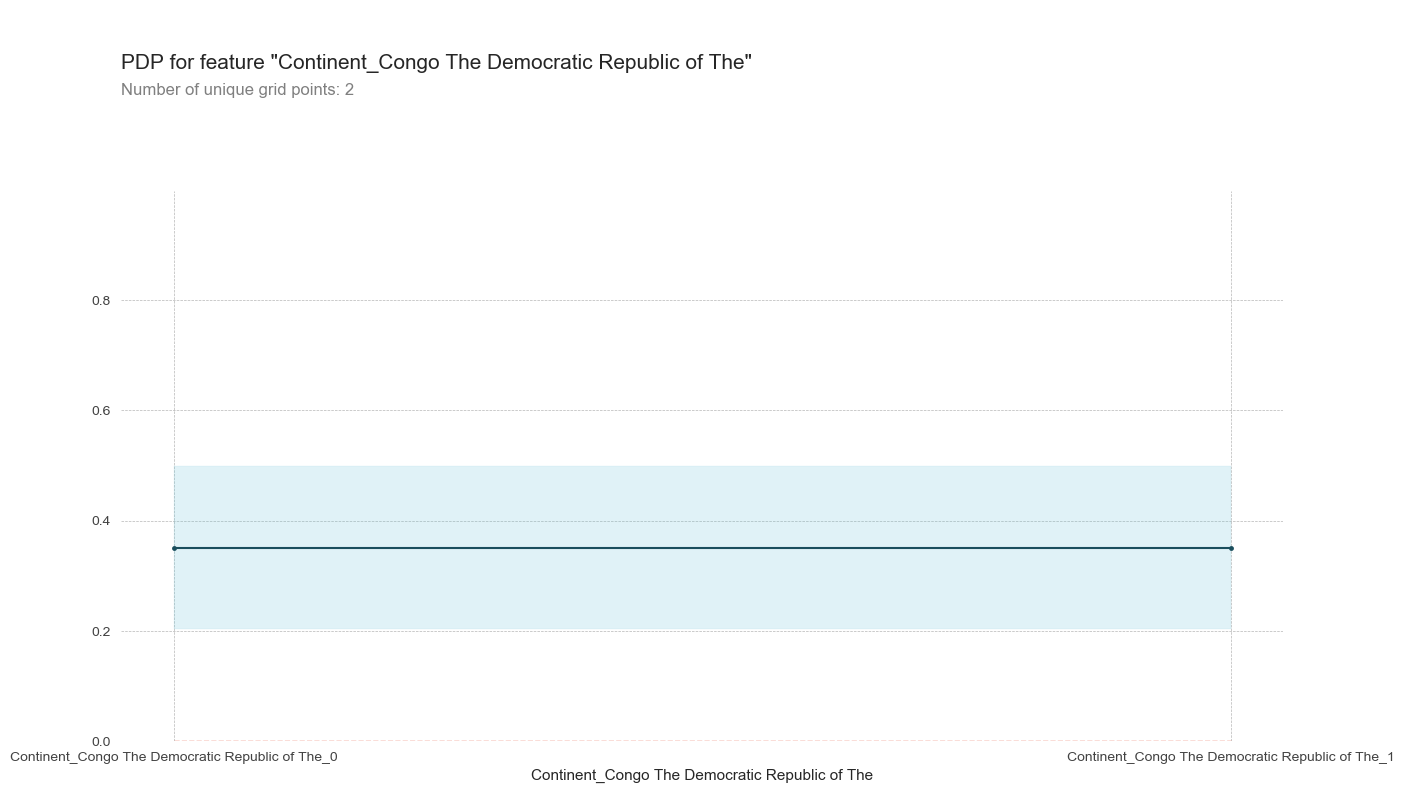

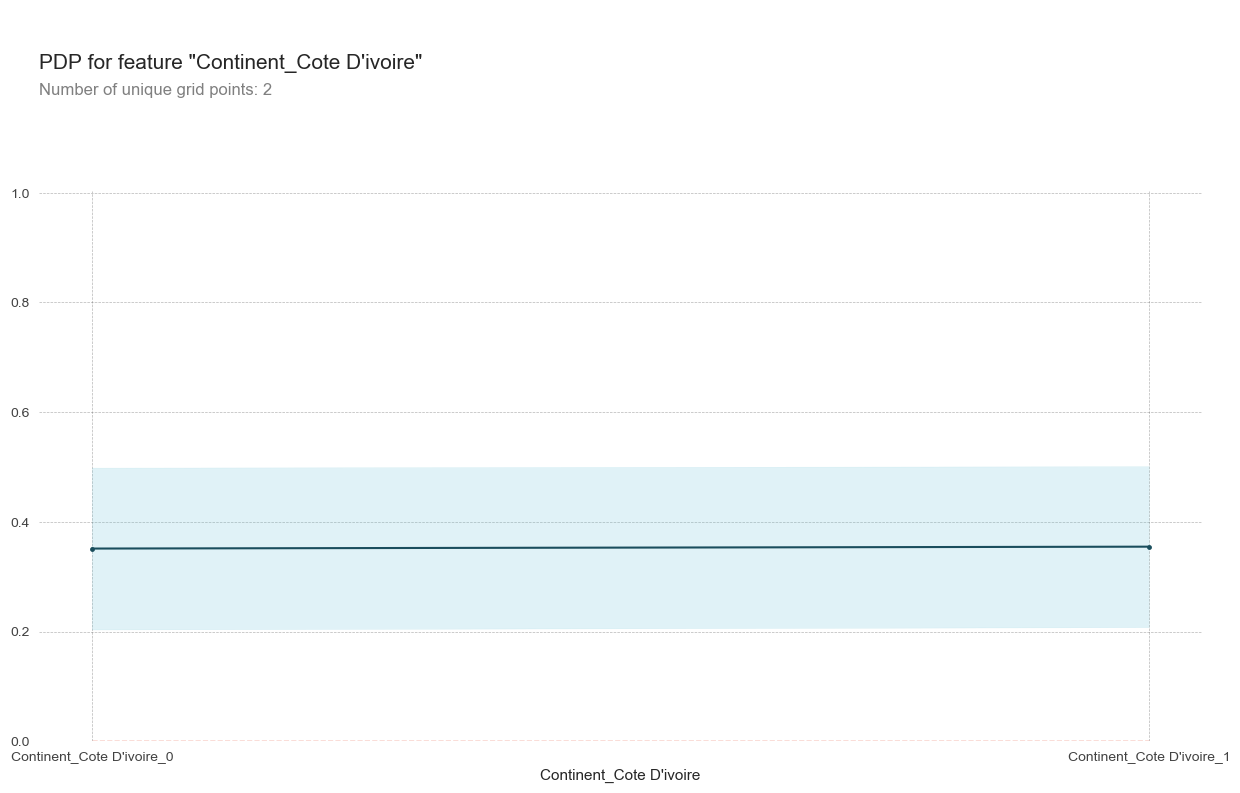

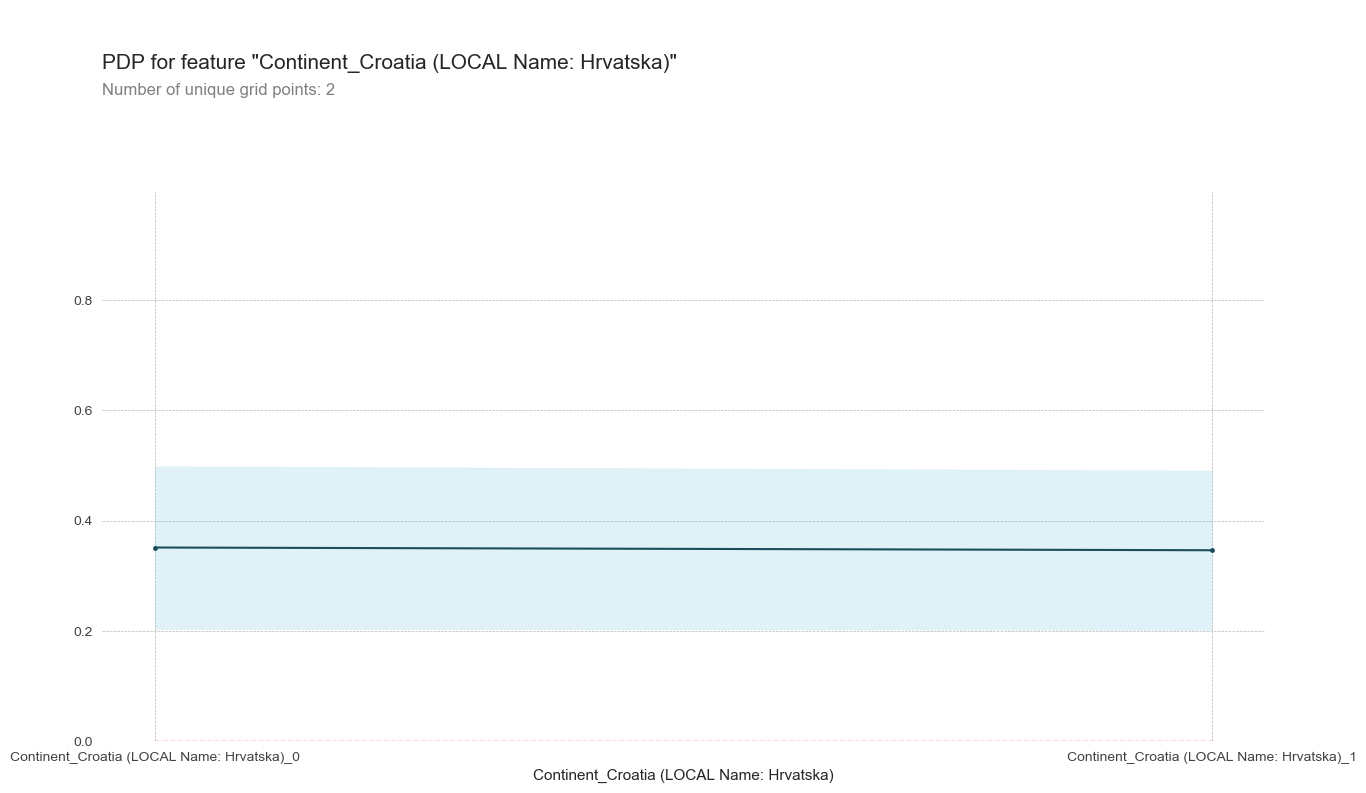

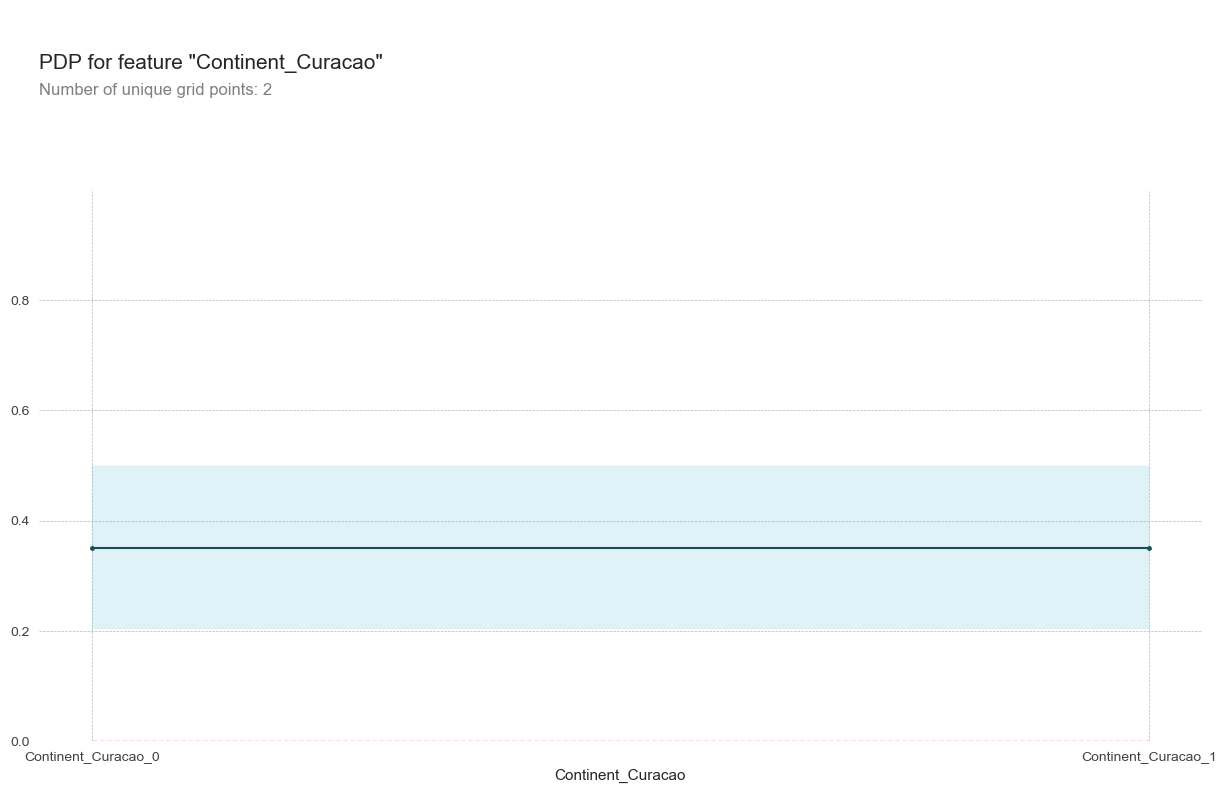

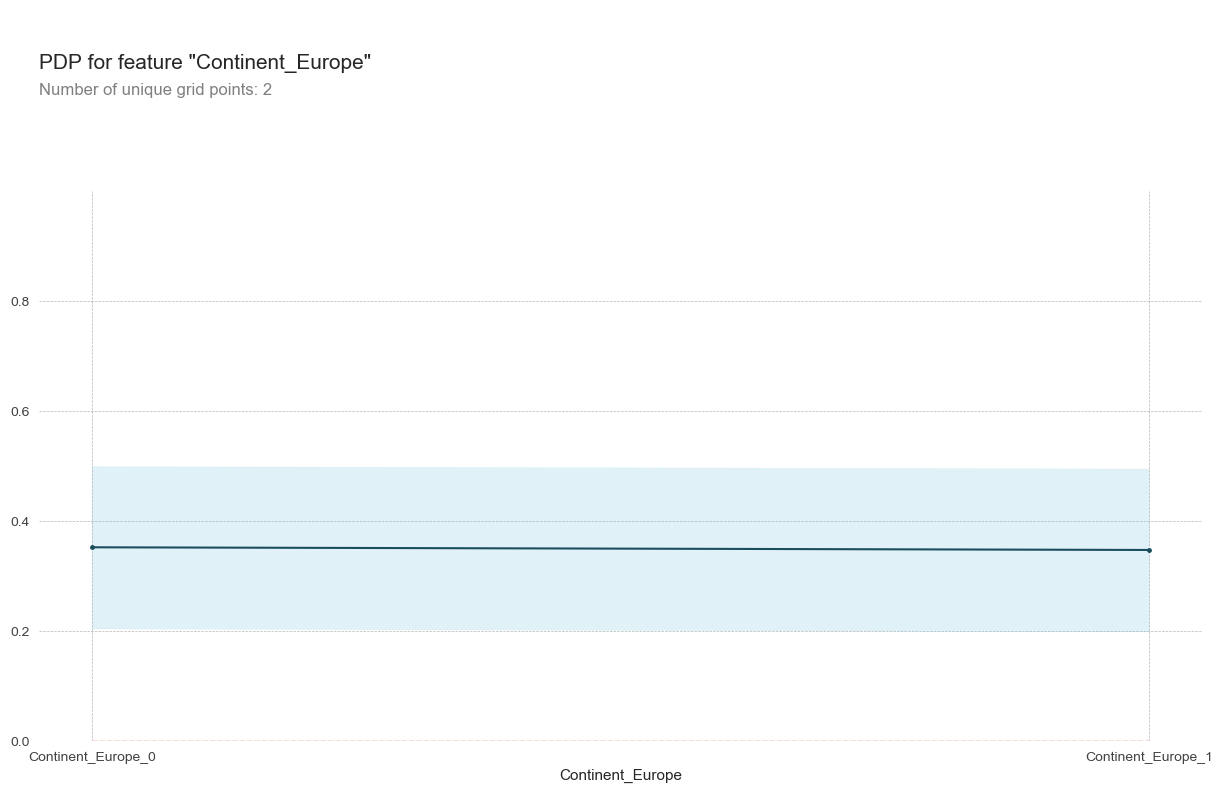

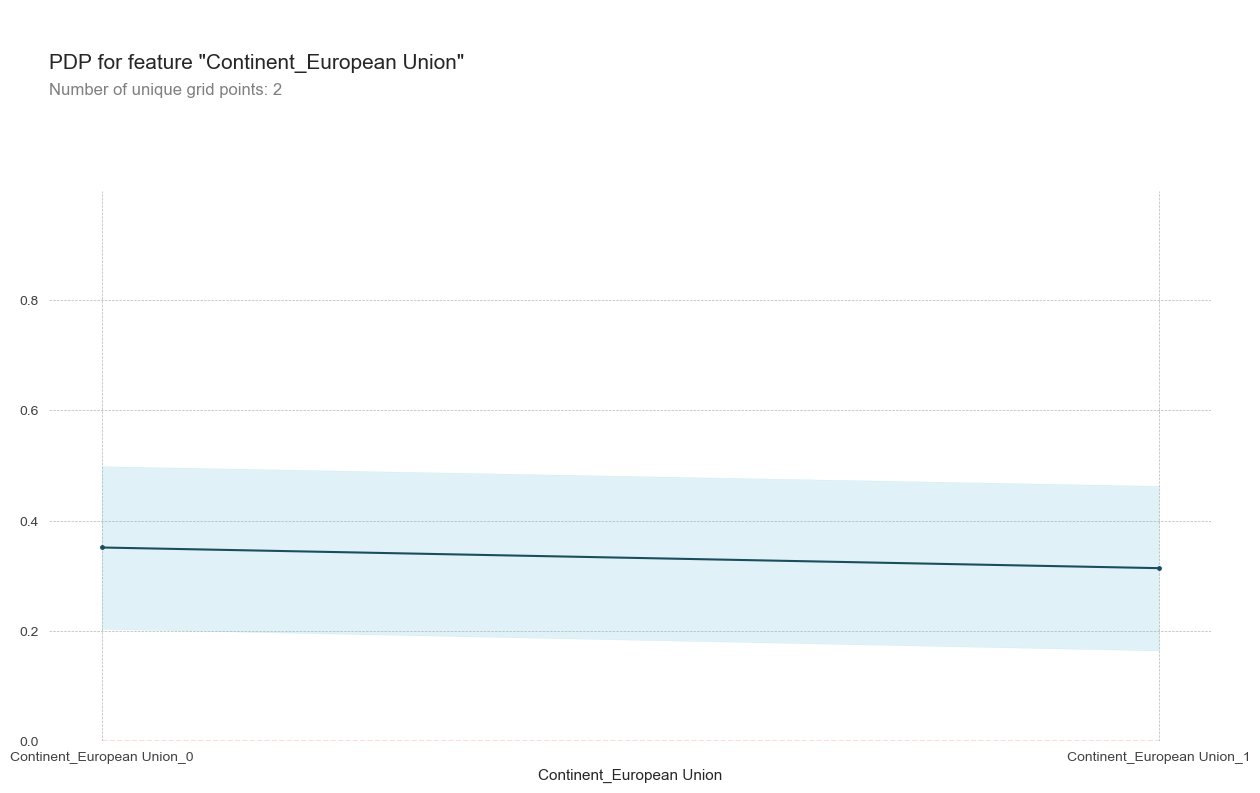

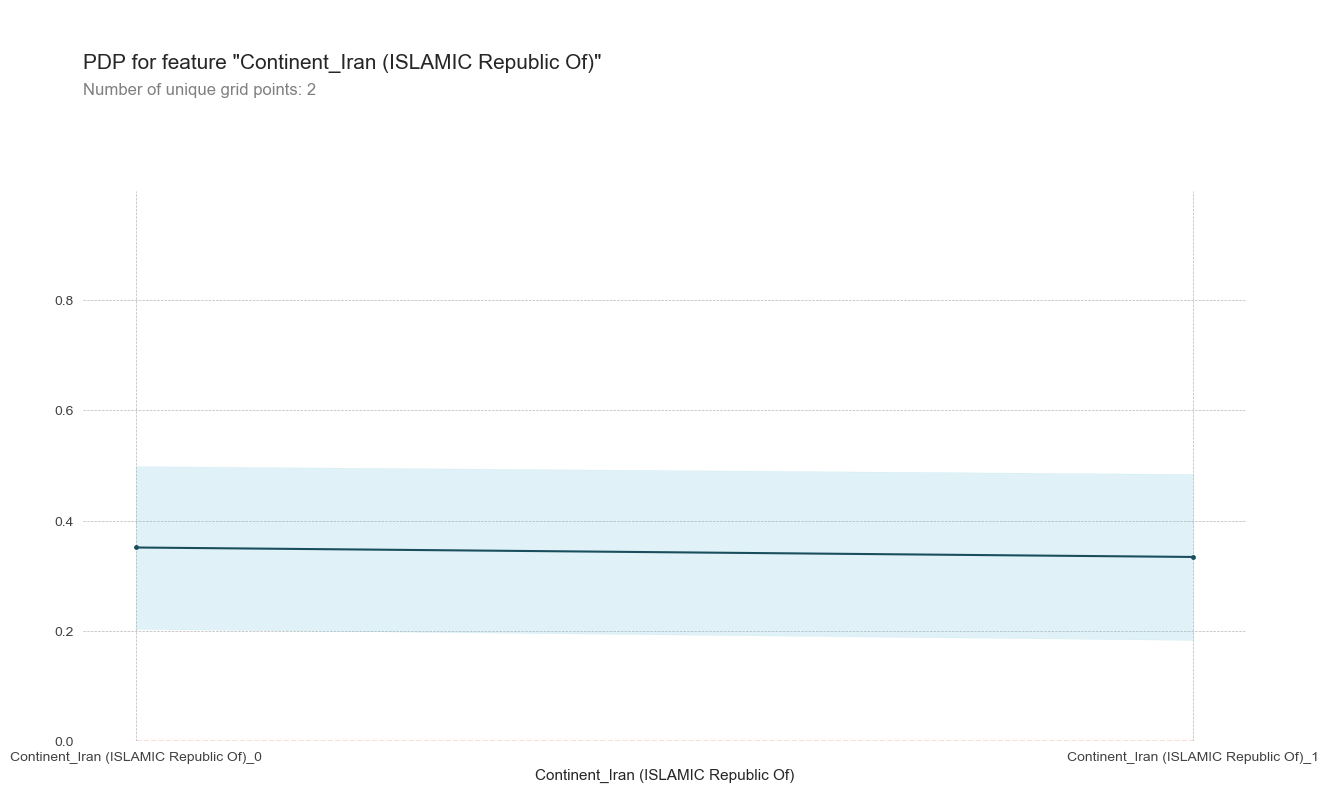

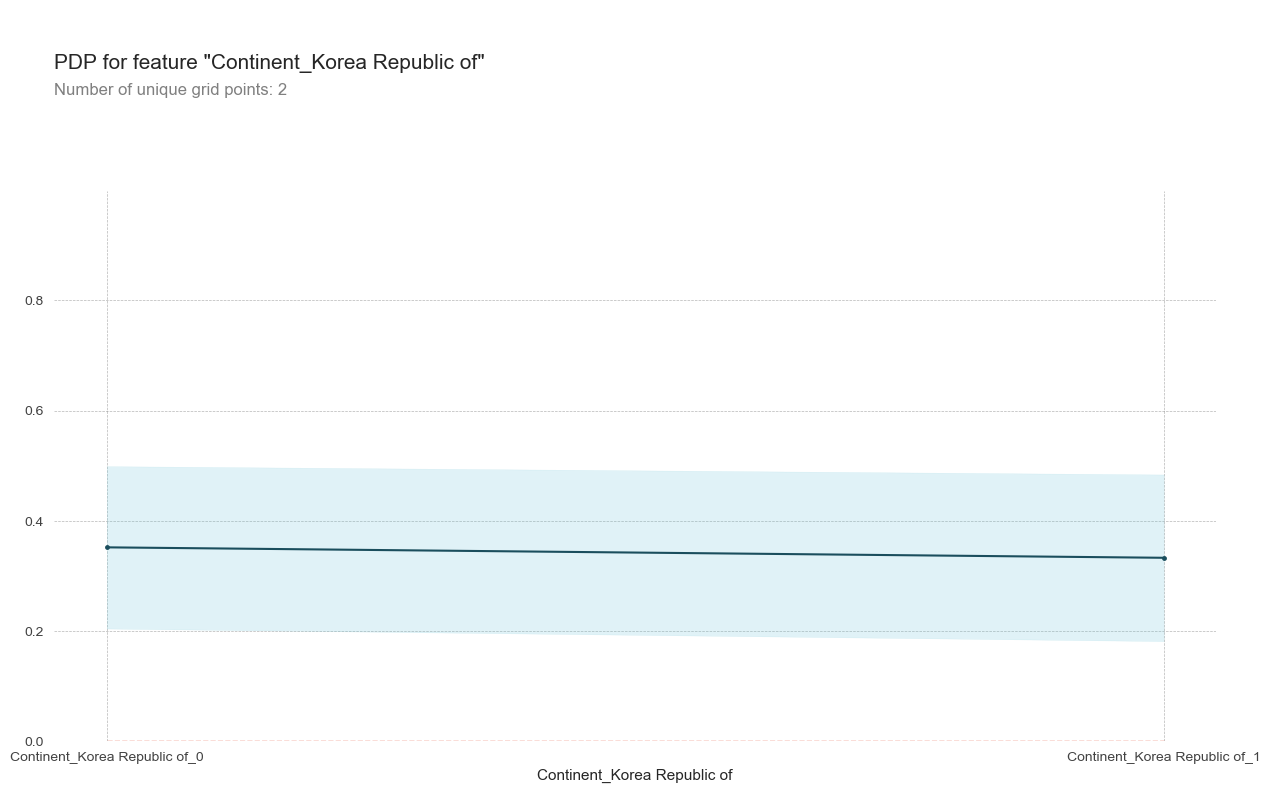

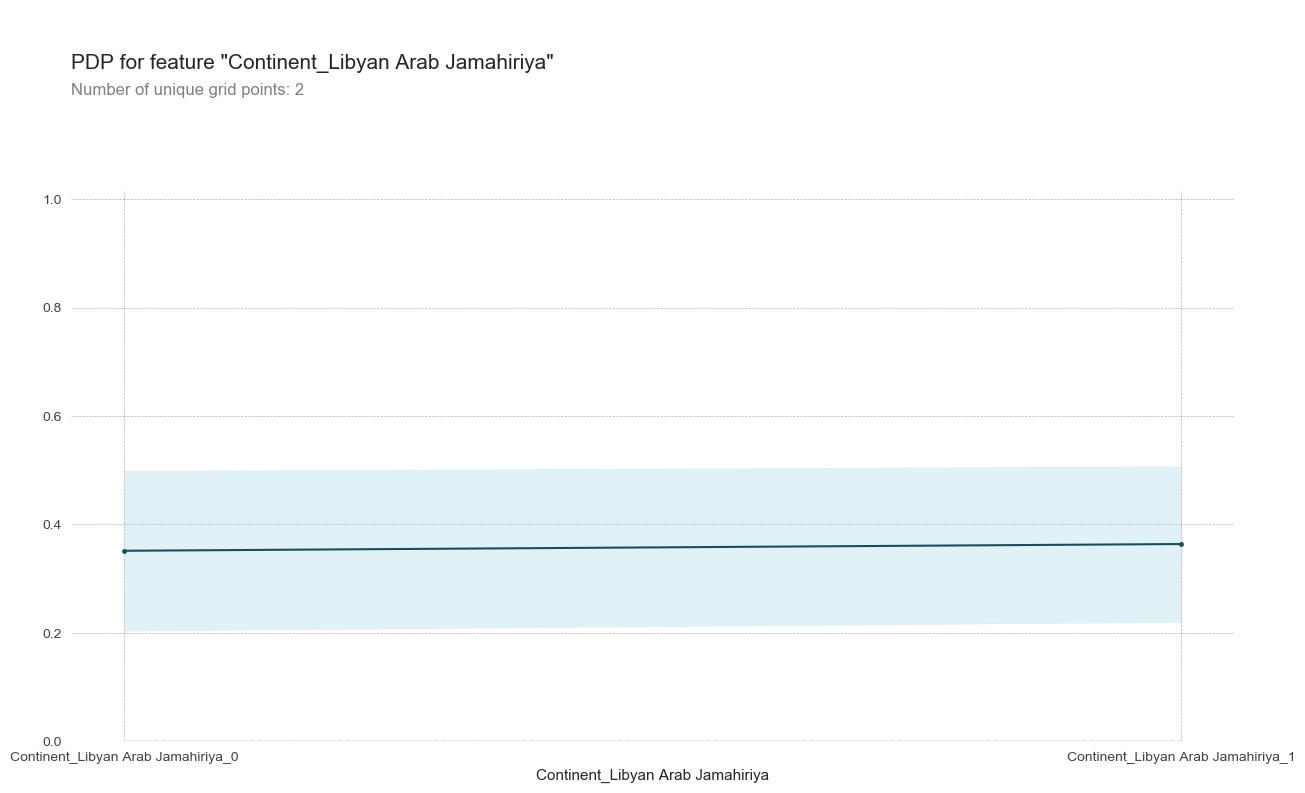

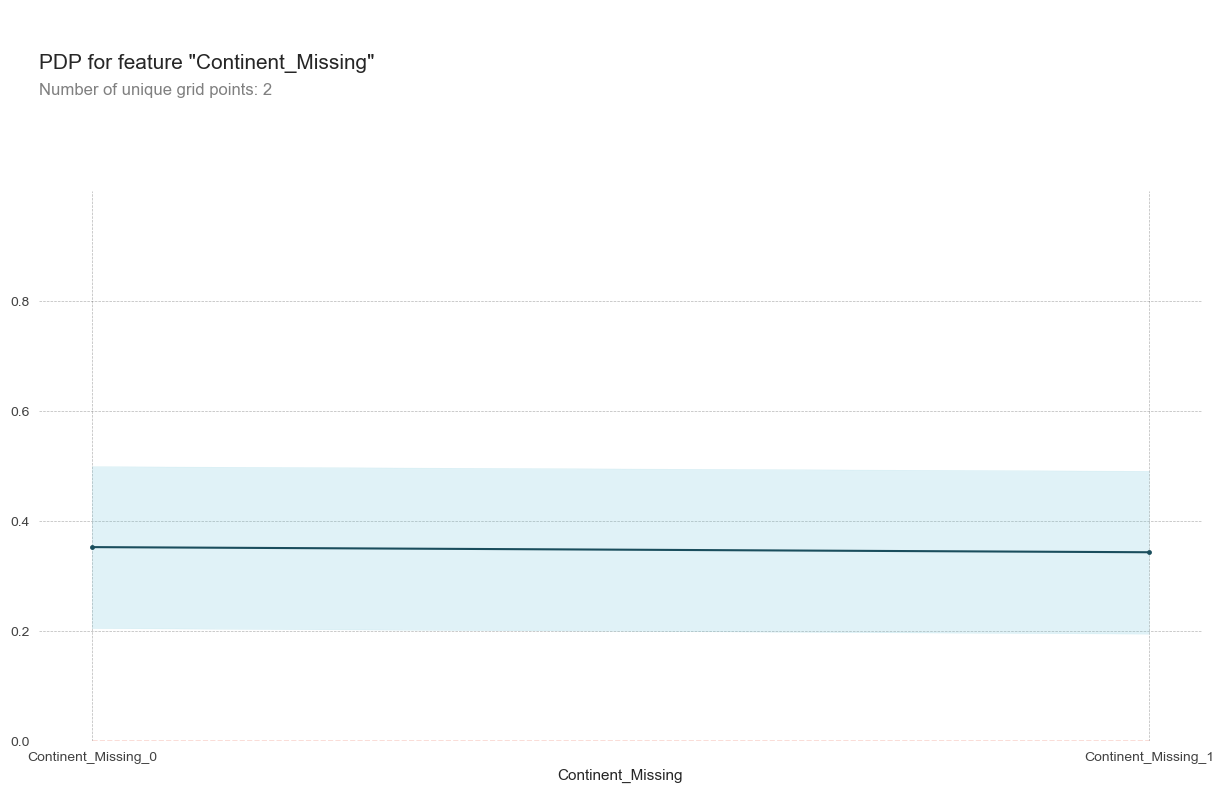

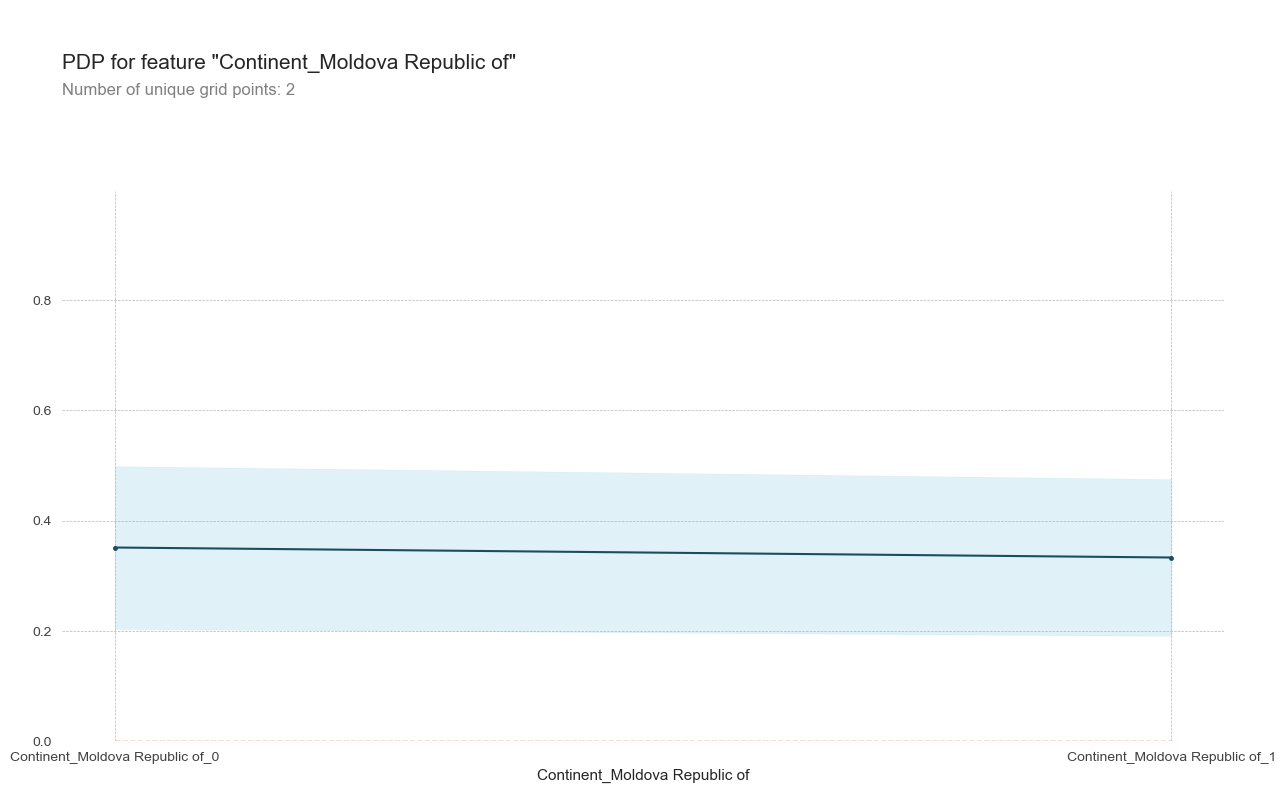

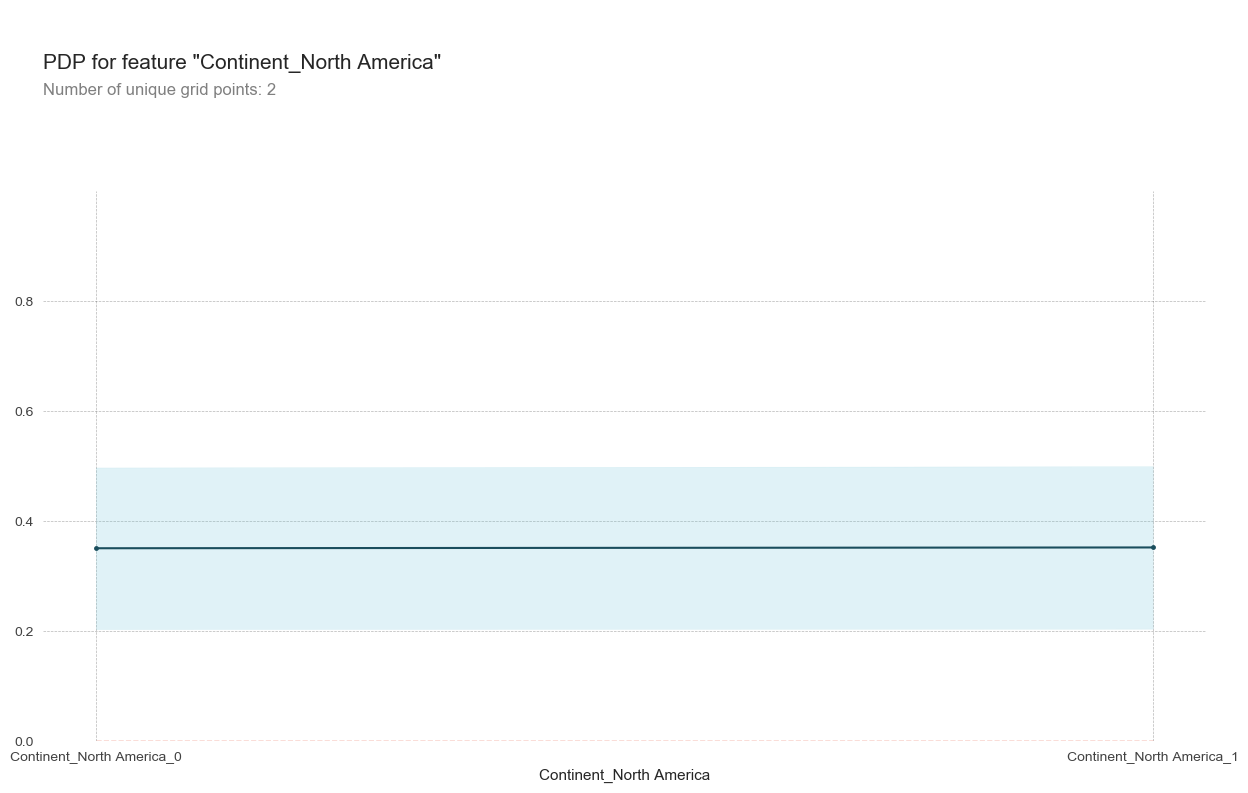

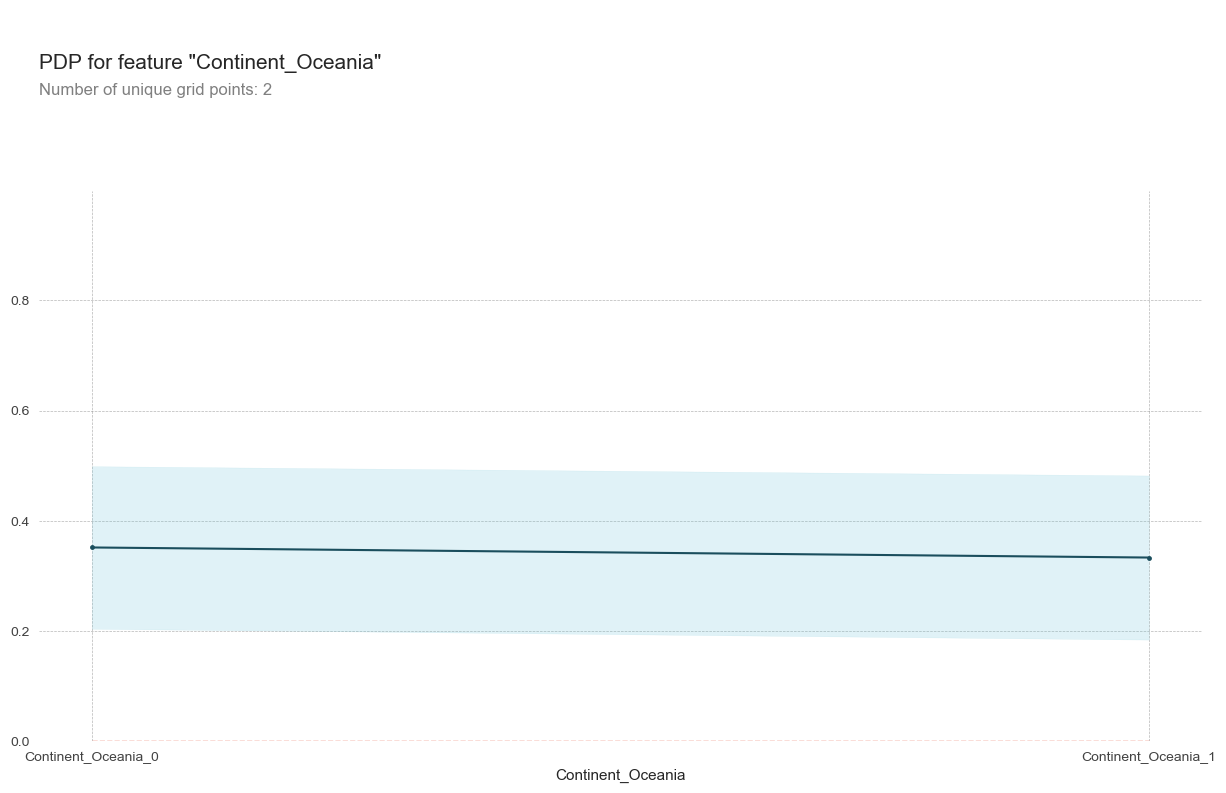

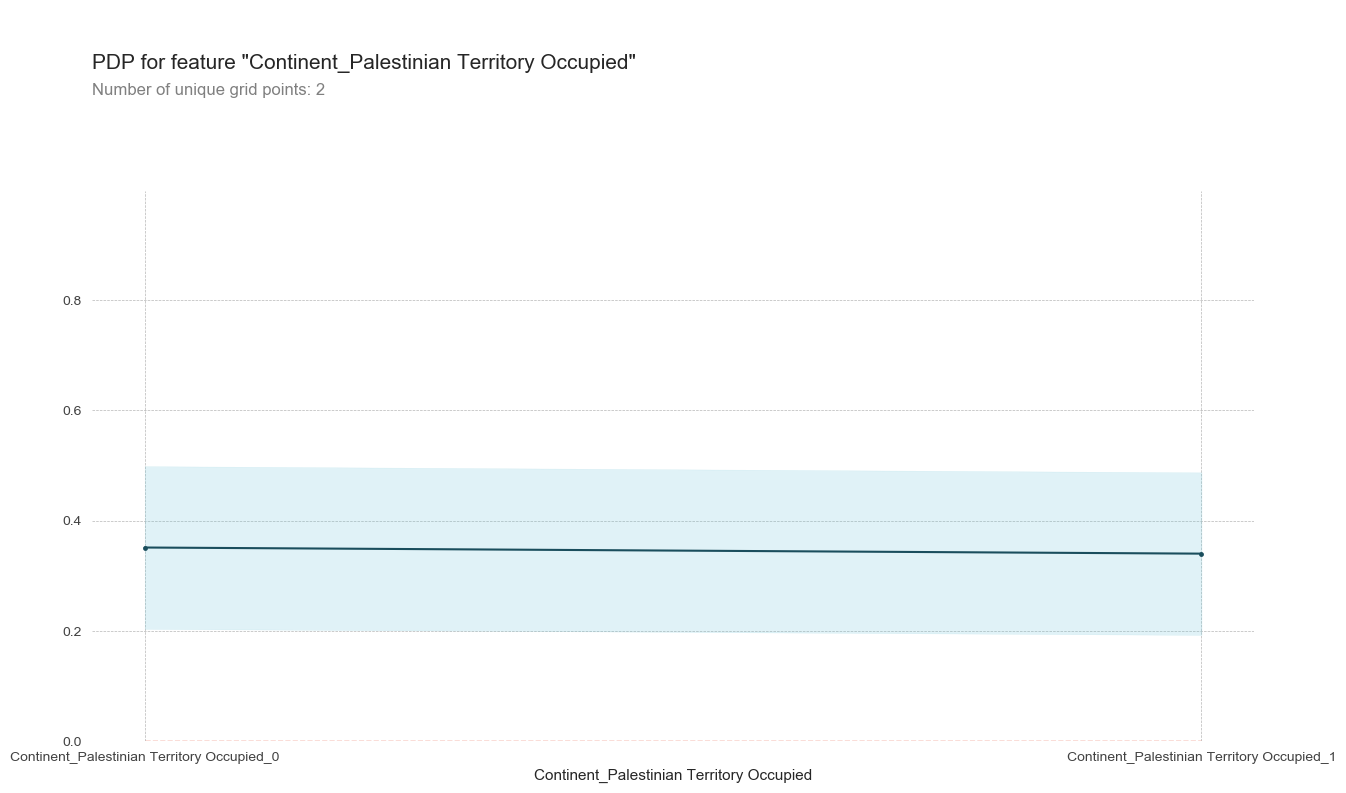

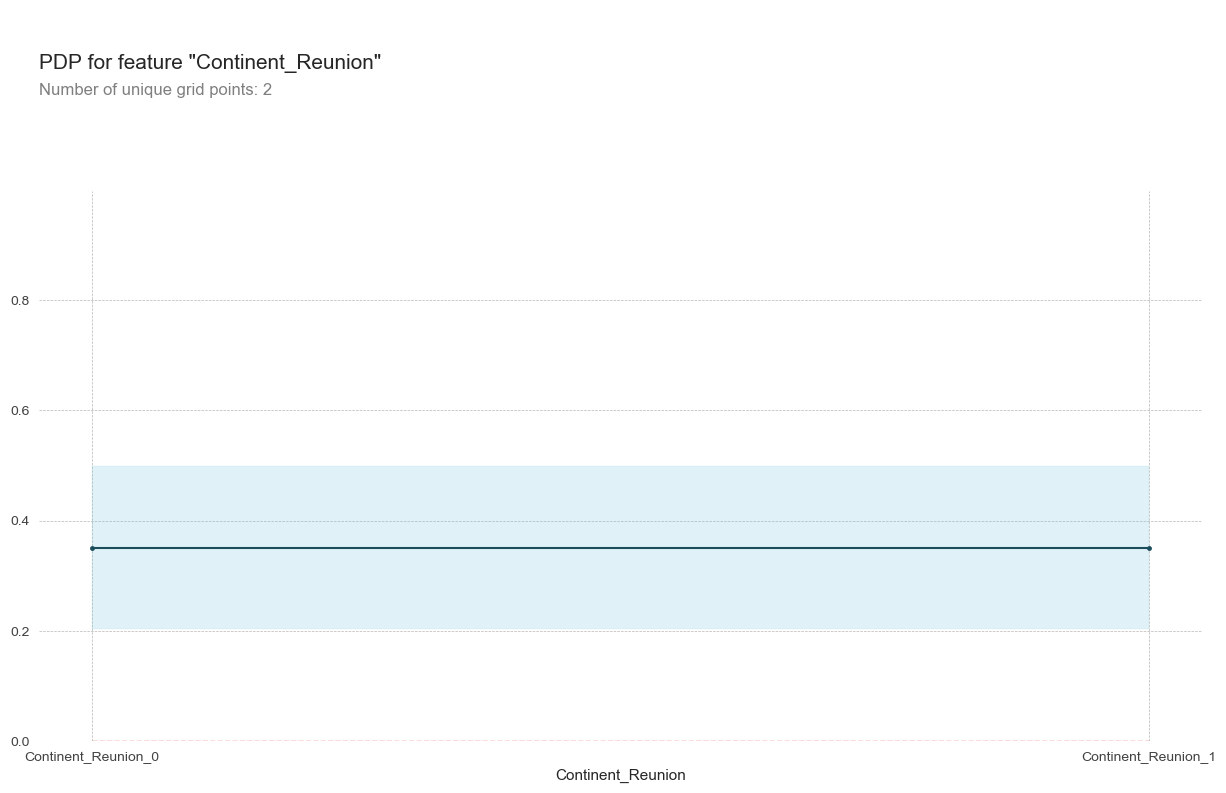

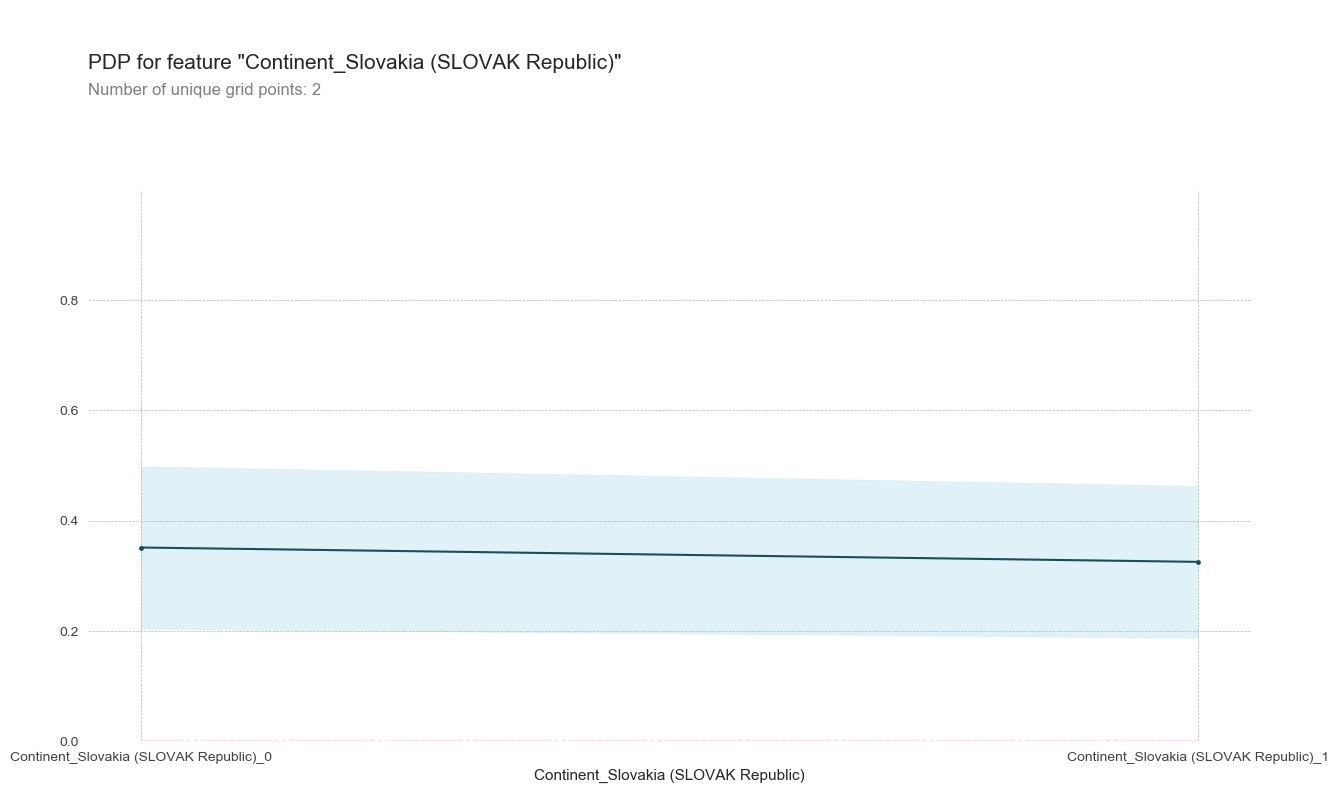

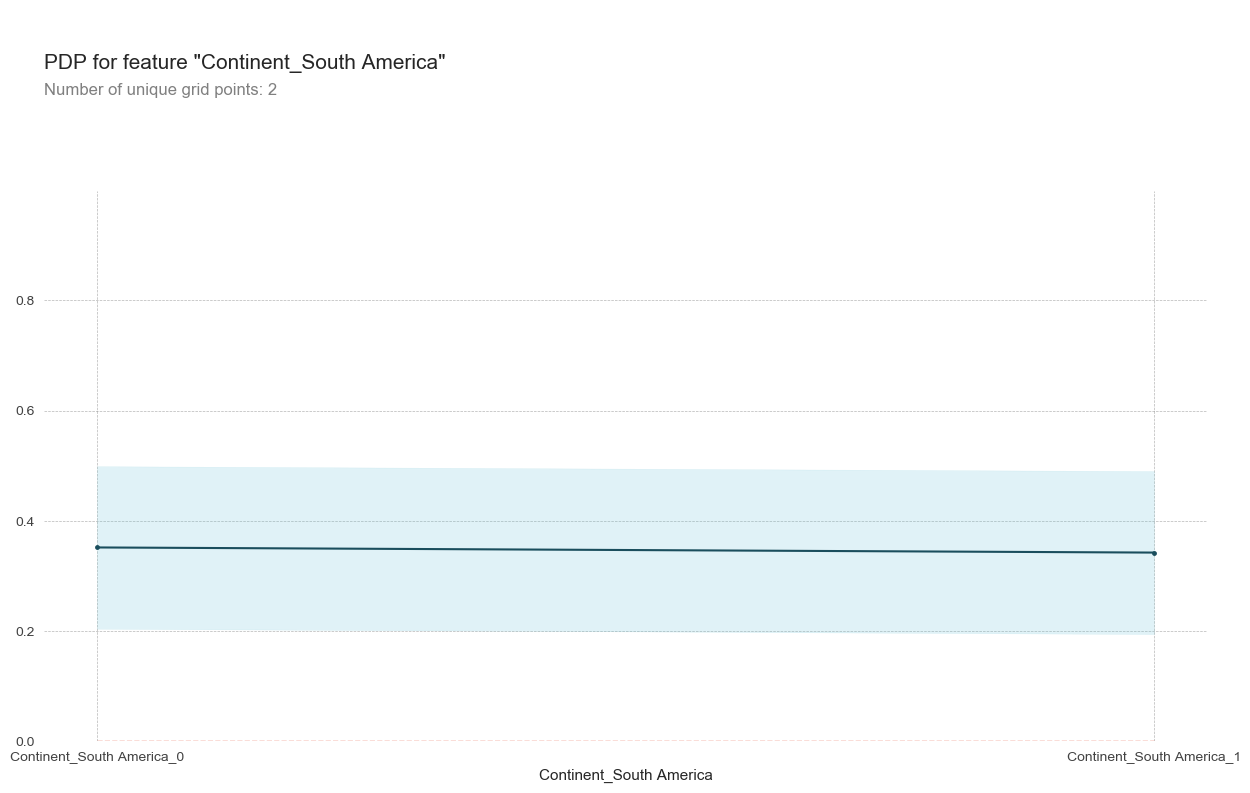

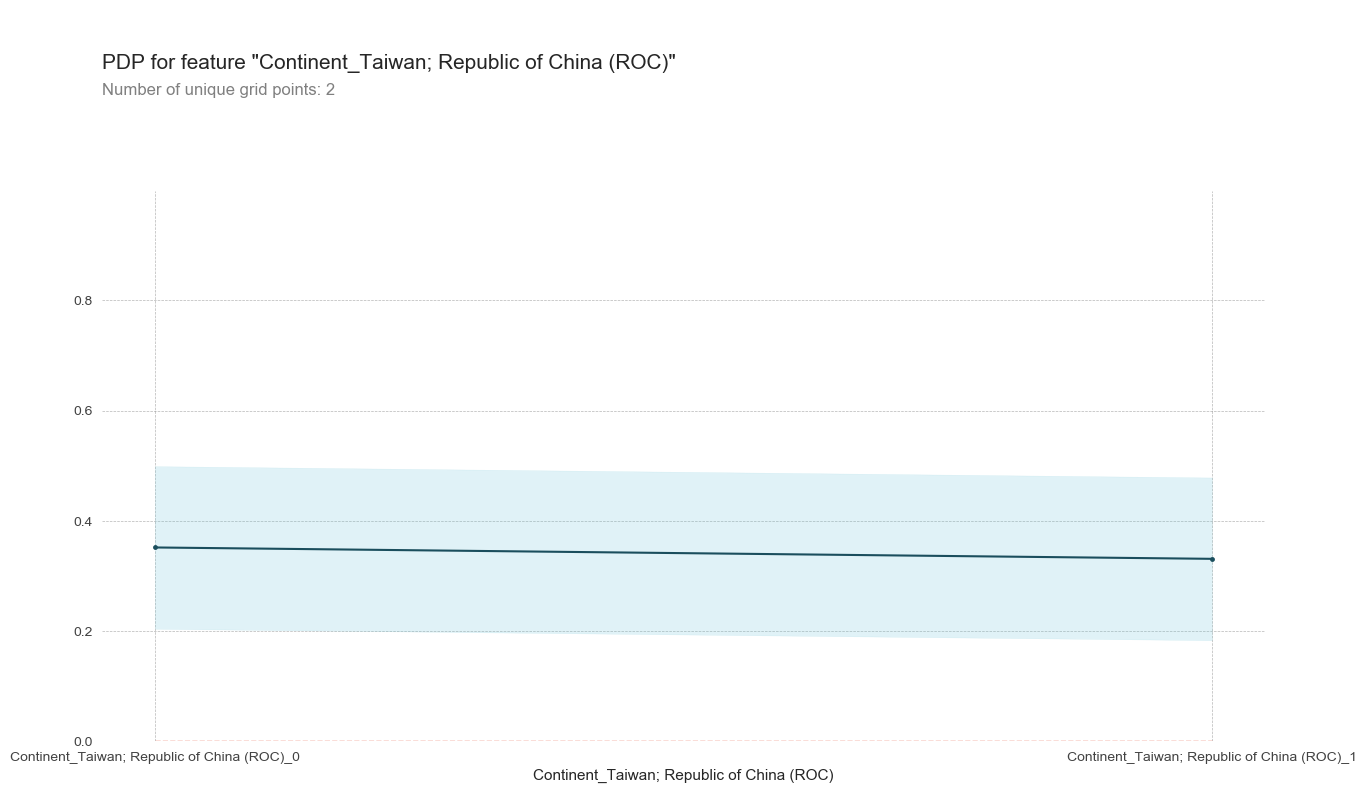

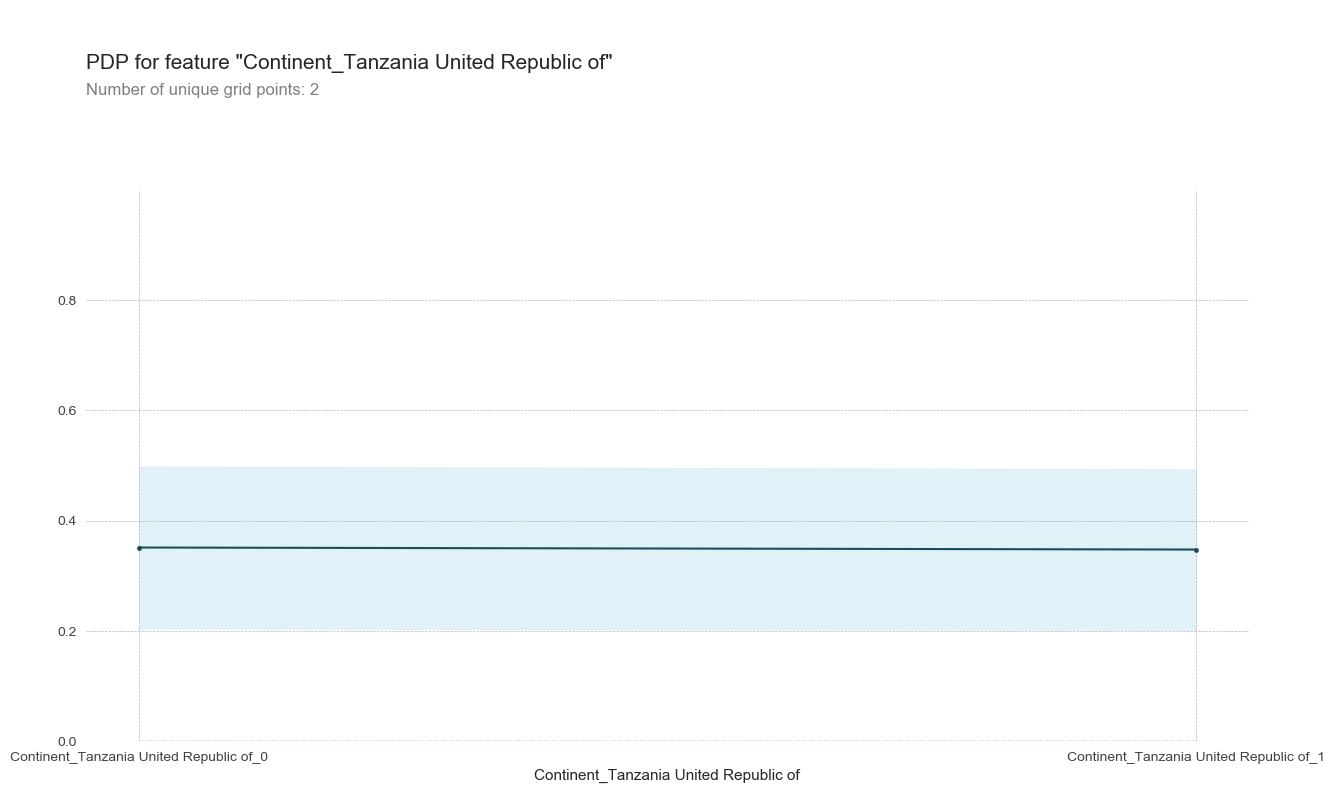

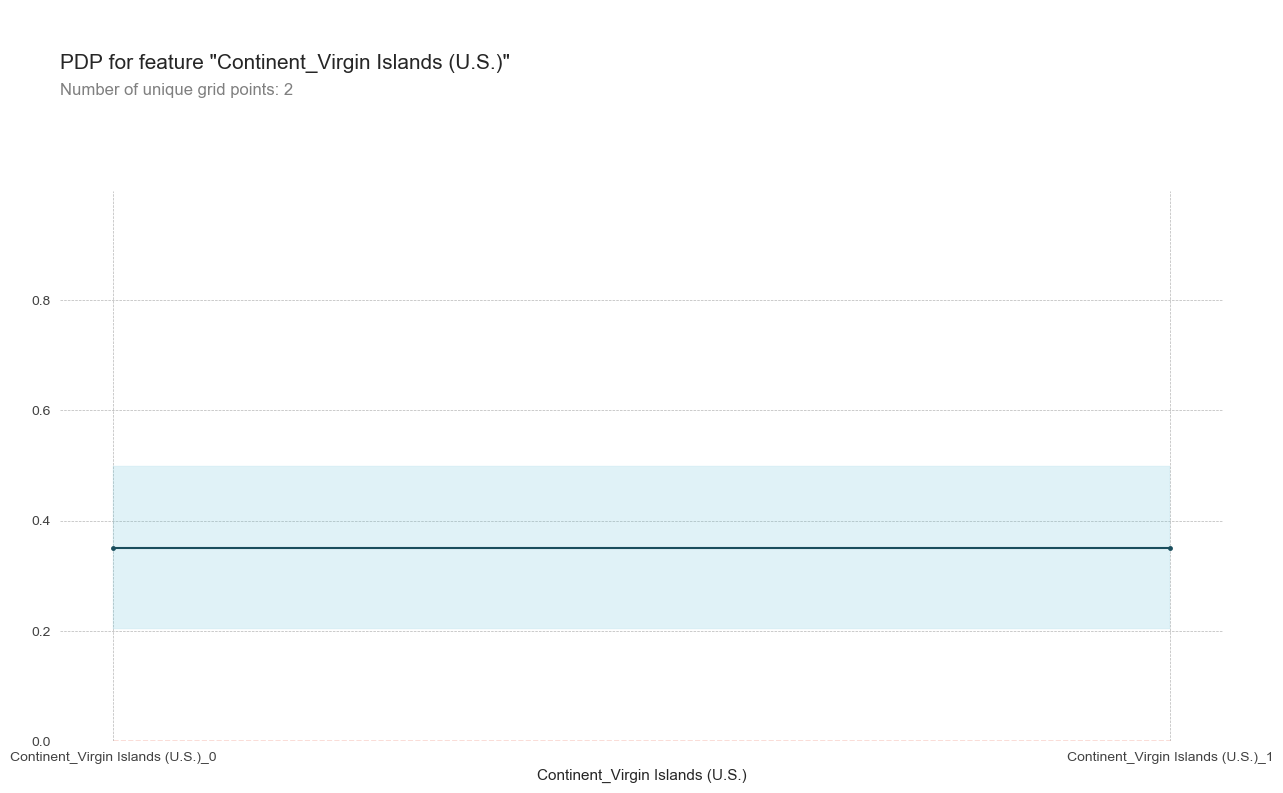

In [295]:
from pdpbox import pdp, info_plots

feat_original = X.columnsb
train_cols = X

# Iterate over all features in X
for feat in feat_original:
  # Create a PDP plot for the current feature
  pdp_version = pdp.pdp_isolate(model=train_model['RF'],
                              dataset=train_cols,
                              model_features=list(train_cols),
                              feature=feat)
  # Plot the PDP plot for the current feature
  pdp.pdp_plot(pdp_version, feat, center=False)


**Insights**:
* The PDP plots for most variables are relatively flat, with the exception of time_diff, quarter 2 3 and 4, purchase_value, and age.
    * There is a higher likelihood of fraudulent activity when the time difference between events is small.
    * Quarters 2, 3, and 4 have a higher probability of fraudulent activity compared to quarter 1.
    * Smaller purchase values tend to have a higher probability of fraudulent activity.
    * Users who are around 20 years of age or younger have a higher probability of committing fraud.

## Business Insights

`Now, let's try to answer the questions:`
1. **Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.**
    * Model: Random Forests
    * The cost of false positives and false negatives can significantly influence the design and optimization of the model. If false positives are costly (e.g., the business incurs significant expenses investigating and taking action on fraudulent activities that turn out to be legitimate), the model may be optimized to minimize false positives. This could be achieved by adjusting the model's threshold for predicting fraud or by using evaluation metrics that prioritize precision (the proportion of true positive predictions among all positive predictions). On the other hand, if false negatives are costly (e.g., the business loses significant revenue when fraudulent activities go undetected), the model may be optimized to minimize false negatives. `This could be done by adjusting the model's threshold or by using evaluation metrics that focus on recall (the proportion of true positive predictions among all actual positive cases).` In summary, the cost of false positives and false negatives can significantly impact the model's performance and the choices made in its design and optimization.
2. **Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?**
    * From a user perspective, random forests make predictions by combining the predictions of multiple decision trees, which are trained on different subsets of the data. Each tree in the random forest makes a prediction based on the features of the input data and the trained decision rules. The random forest model then aggregates the predictions of all the trees and outputs the final prediction based on a majority vote or some other aggregation method. Overall, random forests are able to make accurate predictions by leveraging the collective knowledge of multiple decision trees and aggregating their predictions.
    * There is a higher likelihood of fraudulent activity when the time difference between events is small.
    * Quarters 2, 3, and 4 have a higher probability of fraudulent activity compared to quarter 1.
    * Smaller purchase values tend to have a higher probability of fraudulent activity.
    * Users who are around 20 years of age or younger have a higher probability of committing fraud.
3. **Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?**
    * If the model predicts that an activity is fraudulent, various actions can be taken to protect the user and the business. These actions may include sending alerts, blocking transactions, implementing additional security measures, or personalized the user experience based on perceived risk. Alerts can be sent through notifications on a dashboard or through email or SMS, and transactions can be blocked or flagged for review. Additional security measures may include requesting additional authentication or manual review of the activity, and the user experience can be tailored based on the predicted level of risk.